In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from tensorflow.keras.models import Model
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input, Add, Activation
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import auc, precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna.visualization as vis
import matplotlib.pyplot as plt

/Users/shivamsharma/anaconda3/envs/masters/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [90]:
import shap

In [2]:
import optuna
from sklearn.metrics import f1_score

In [3]:
ratio_data = pd.read_csv("ratio.csv")

In [98]:
ratio_data.head(10)

index                 grp  Age  Gender  \
0  1002P  normal_colonoscopy   60    Male   
1   100N            negative   64  Female   
2   100P              cancer   64    Male   
3   101N            negative   60  Female   
4   101P  normal_colonoscopy   67  Female   
5   102N            negative   62    Male   
6   103N            negative   62    Male   
7  1041P  normal_colonoscopy   73    Male   
8  1049P                high   72    Male   
9   104N            negative   60    Male   

   D_0__Archaea.D_1__Euryarchaeota.D_2__Methanobacteria.D_3__Methanobacteriales.D_4__Methanobacteriaceae  \
0                                           0.000290                                                       
1                                           0.000000                                                       
2                                           0.000000                                                       
3                                           0.000000                                                       
4                                           0.000000                                                       
5                                           0.000000                                                       
6                                           0.000267                                                       
7                                           0.000068                                                       
8                                           0.000000                                                       
9                                           0.000000                                                       

   D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Actinomycetales.D_4__Actinomycetaceae  \
0                                           0.000168                                                  
1                                           0.000259                                                  
2                                           0.000000                                                  
3                                           0.000148                                                  
4                                           0.000131                                                  
5                                           0.000342                                                  
6                                           0.000000                                                  
7                                           0.000342                                                  
8                                           0.000474                                                  
9                                           0.000000                                                  

   D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Bifidobacteriales.D_4__Bifidobacteriaceae  \
0                                           0.002133                                                      
1                                           0.019011                                                      
2                                           0.006305                                                      
3                                           0.021590                                                      
4                                           0.072117                                                      
5                                           0.055914                                                      
6                                           0.017609                                                      
7                                           0.004349                                                      
8                                           0.025514                                                      
9                                           0.000888                                                      

   D_0

In [6]:
#Function for filtering the data based on specific groups

def filter_data(groups, target_positive):
    filtered = ratio_data[ratio_data['grp'].isin(groups)].copy()
    filtered.loc[:, 'target'] = filtered['grp'].apply(lambda x: 1 if x == target_positive else 0)
    return filtered

In [7]:
# Function for data preparation for train and test

def prepare_data(filtered):
    train_data, test_data = train_test_split(filtered, test_size=0.2, random_state=123)
    
    feature_names_list = train_data.drop(columns=['index', 'grp', 'target']).columns.tolist()

    train_x = train_data.drop(columns=['index', 'grp', 'target'])
    train_y = train_data['target']
    test_x = test_data.drop(columns=['index', 'grp', 'target'])
    test_y = test_data['target']

    # Encode categorical features if necessary
    for col in train_x.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        train_x[col] = le.fit_transform(train_x[col])
        test_x[col] = le.transform(test_x[col])

    return train_x, train_y, test_x, test_y, feature_names_list


In [8]:
cancer_vs_adenoma = filter_data(['cancer', 'low', 'intermediate', 'high'], 'cancer')

train_x, train_y, test_x, test_y, feature_names_list = prepare_data(cancer_vs_adenoma)

In [9]:
cancer_vs_adenoma.head()

index           grp  Age  Gender  \
2    100P        cancer   64    Male   
8   1049P          high   72    Male   
14   106P        cancer   71  Female   
16   107P  intermediate   62    Male   
17  1082P           low   64  Female   

    D_0__Archaea.D_1__Euryarchaeota.D_2__Methanobacteria.D_3__Methanobacteriales.D_4__Methanobacteriaceae  \
2                                            0.000000                                                       
8                                            0.000000                                                       
14                                           0.000000                                                       
16                                           0.000244                                                       
17                                           0.000000                                                       

    D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Actinomycetales.D_4__Actinomycetaceae  \
2                                            0.000000                                                  
8                                            0.000474                                                  
14                                           0.000141                                                  
16                                           0.000115                                                  
17                                           0.000000                                                  

    D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Bifidobacteriales.D_4__Bifidobacteriaceae  \
2                                            0.006305                                                      
8                                            0.025514                                                      
14                                           0.113352                                                      
16                                           0.003355                                                      
17                                           0.002939                                                      

    D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Corynebacteriales.D_4__Corynebacteriaceae  \
2                                                 0.0                                                      
8                                                 0.0                                                      
14                                                0.0                                                      
16                                                0.0                                                      
17                                                0.0                                                      

    D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Micrococcales.D_4__Micrococcaceae  \
2                                            0.000000                                              
8                                            0.000092                                              
14                                           0.000000                                              
16                                           0.000000                                              
17                                           0.000000                                              

    D_0__Bacteria.D_1__Actinobacteria.D_2__Coriobacteriia.D_3__Coriobacteriales.D_4__Coriobacteriaceae  \
2                                            0.001446                                                    
8                                            0.003611                                                    
14                                           0.005121                                                    
16                                           0.008415                                                    
17                                           0.003583 

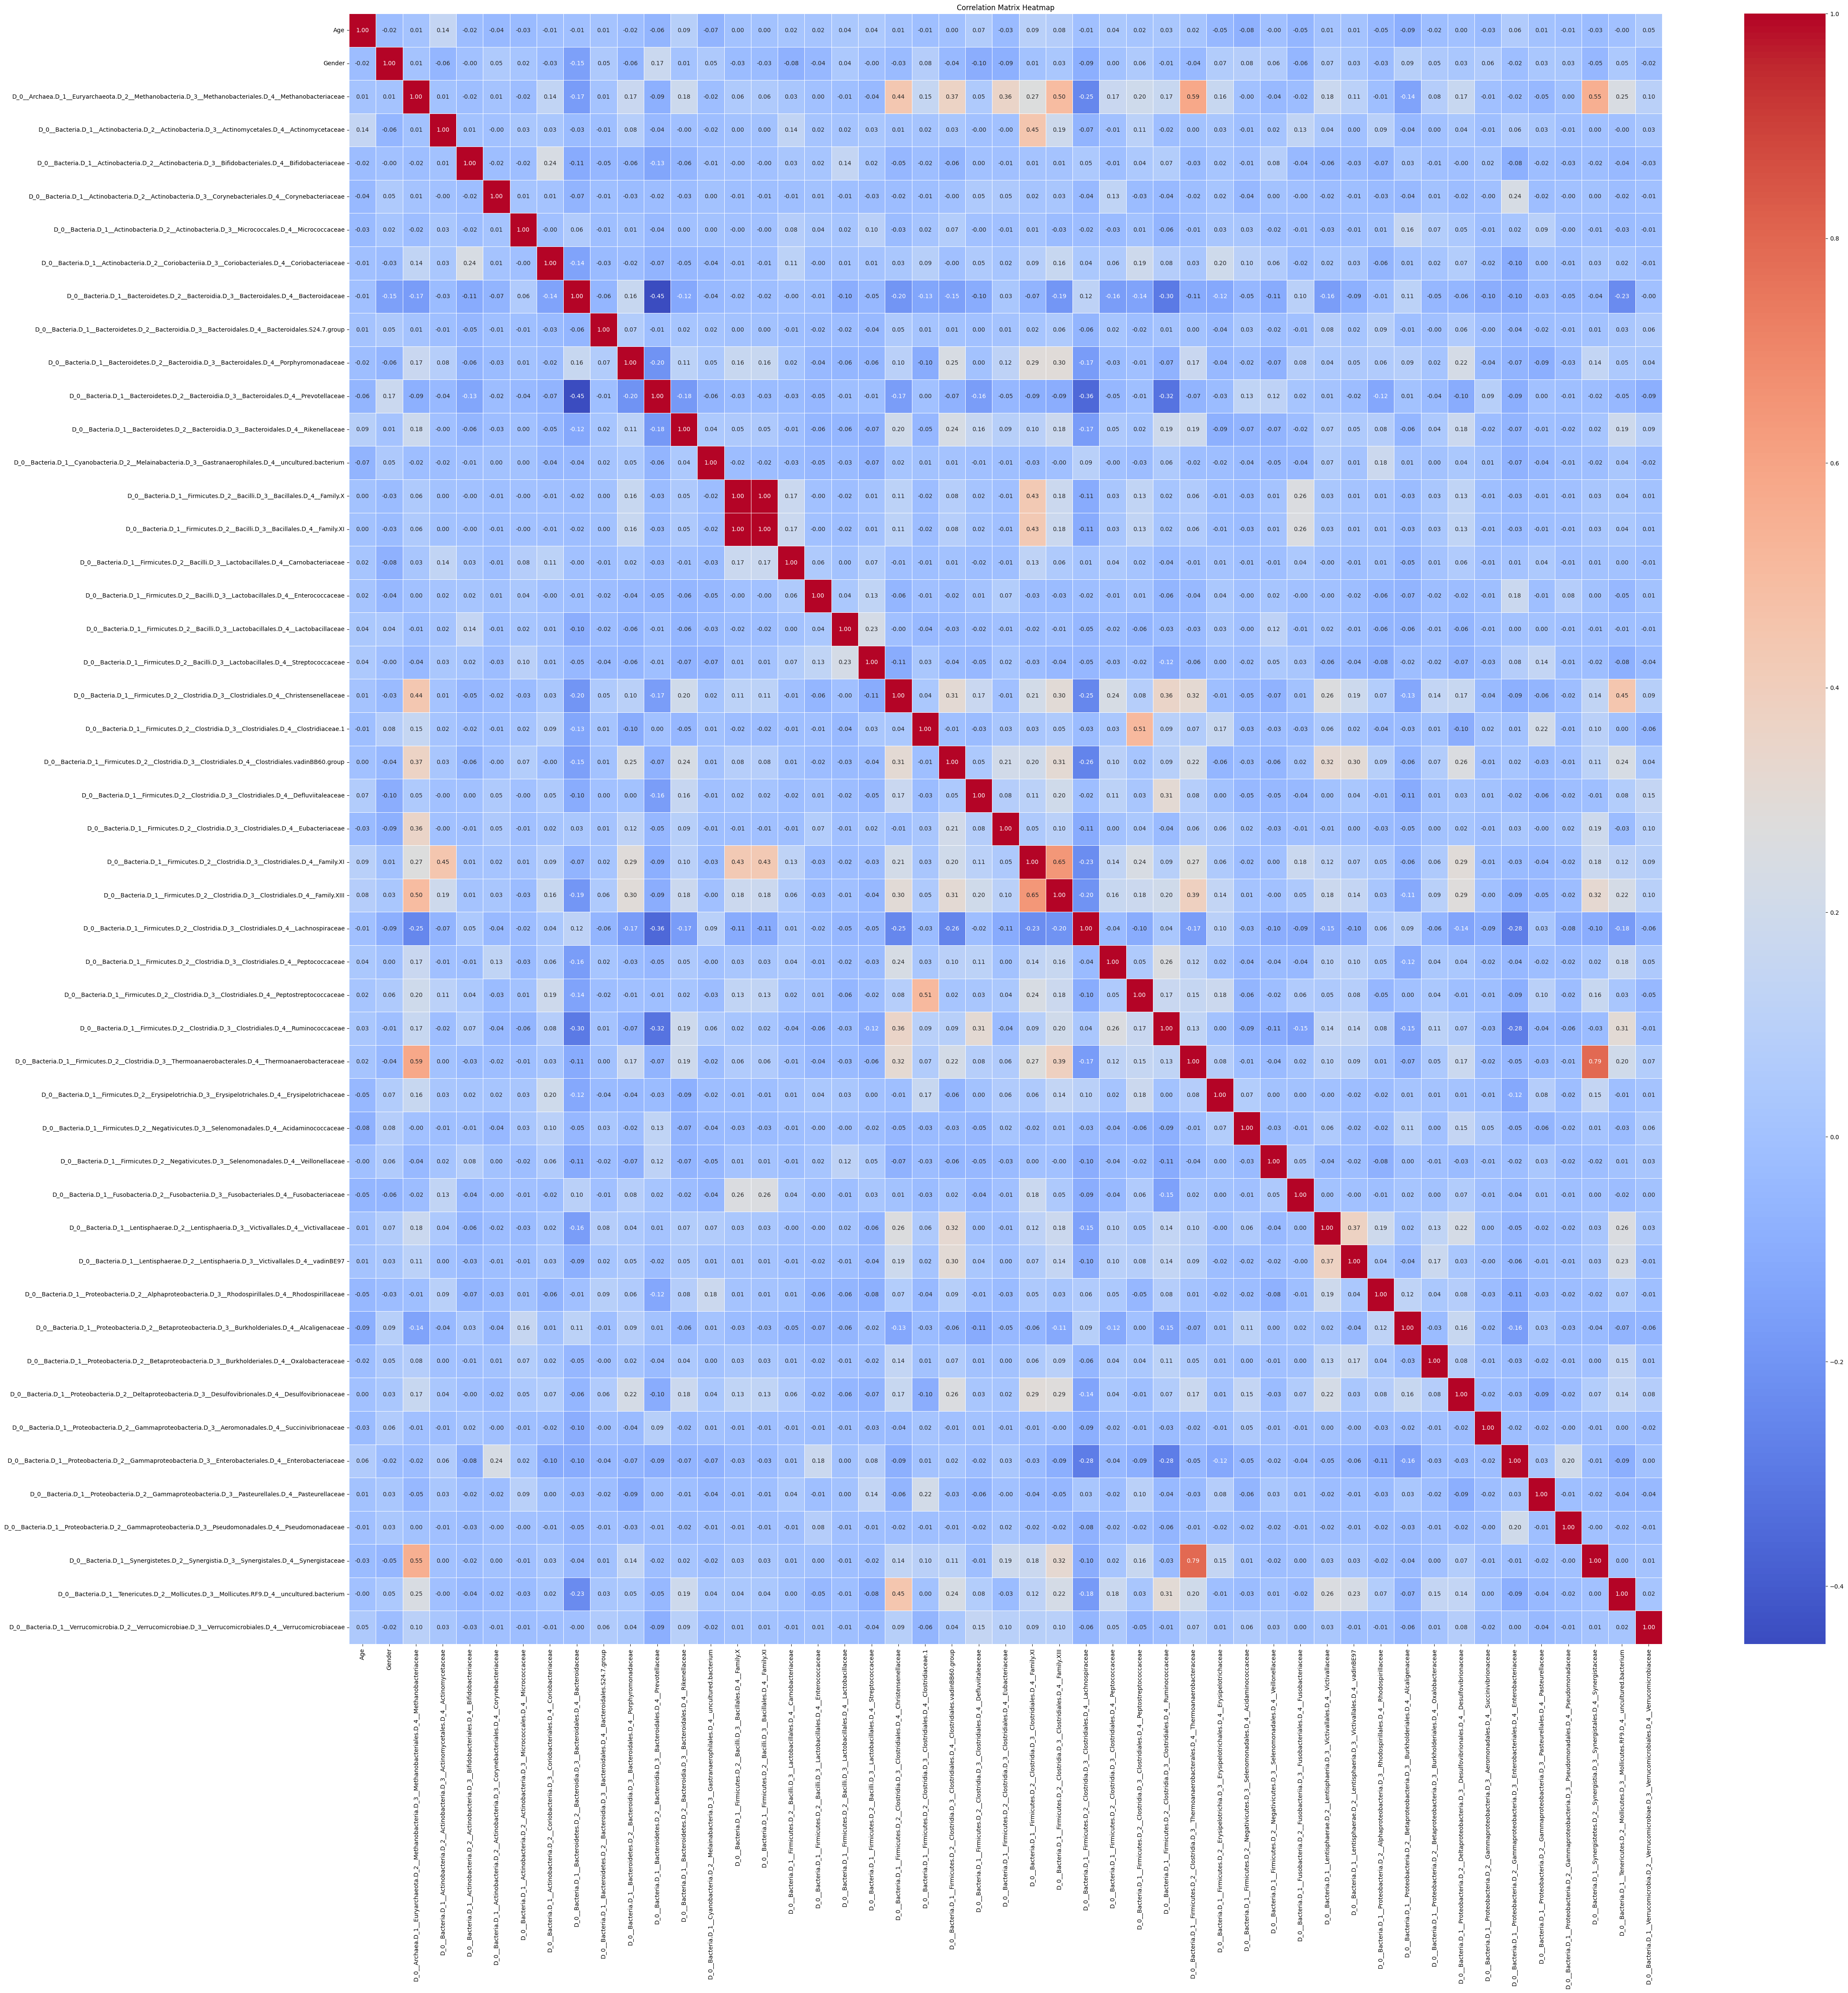

In [10]:
#CORRELATION ANALYSIS:

df = pd.DataFrame(train_x)

correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(50, 50))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [11]:

threshold = 0.5 
high_corr_features = np.where(np.abs(correlation_matrix) > threshold)
high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]

print("Highly correlated feature pairs with correlation above threshold:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {correlation_matrix.loc[pair[0], pair[1]]}")

Highly correlated feature pairs with correlation above threshold:
D_0__Archaea.D_1__Euryarchaeota.D_2__Methanobacteria.D_3__Methanobacteriales.D_4__Methanobacteriaceae and D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Family.XIII: 0.5008783757089146
D_0__Archaea.D_1__Euryarchaeota.D_2__Methanobacteria.D_3__Methanobacteriales.D_4__Methanobacteriaceae and D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Thermoanaerobacterales.D_4__Thermoanaerobacteraceae: 0.5852034676133323
D_0__Archaea.D_1__Euryarchaeota.D_2__Methanobacteria.D_3__Methanobacteriales.D_4__Methanobacteriaceae and D_0__Bacteria.D_1__Synergistetes.D_2__Synergistia.D_3__Synergistales.D_4__Synergistaceae: 0.5525283453977606
D_0__Bacteria.D_1__Firmicutes.D_2__Bacilli.D_3__Bacillales.D_4__Family.X and D_0__Bacteria.D_1__Firmicutes.D_2__Bacilli.D_3__Bacillales.D_4__Family.XI: 0.999996993853566
D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Clostridiaceae.1 and D_0__Bacteria.D_1__Fi

In [12]:
correlation_matrix.to_csv("correlation_microbiome.csv")

In [13]:
def evaluate_model(y_true, y_pred, y_pred_prob, title='Model Evaluation'):
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC): {title}')
    plt.legend(loc="lower right")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {title}')
    plt.show()

    f1 = f1_score(y_true, y_pred)
    print(f'F1-Score: {f1}')

In [14]:
# Define CV_ROC function
def CV_ROC(model, X, y, n_splits=10):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(10, 8))
    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_val_pred_prob = model.predict_proba(X.iloc[val_idx])[:, 1]
        fpr, tpr, _ = roc_curve(y.iloc[val_idx], y_val_pred_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Cross-Validation ROC')
    plt.legend(loc='lower right')
    plt.show()

    print(f"Cross-validation AUC Scores: {aucs}")
    print(f"Mean Cross-validation AUC: {mean_auc:.4f}")

1. RANDOM FOREST MODEL

In [15]:
rf = RandomForestClassifier(n_estimators=400, random_state=42)
rf.fit(train_x, train_y)

RandomForestClassifier(n_estimators=400, random_state=42)

In [16]:
# Predictions
#test_y_pred_rf = rf.predict(test_x)
test_y_pred_prob_rf = rf.predict_proba(test_x)[:, 1]
test_y_pred_rf = (test_y_pred_prob_rf > 0.4).astype(int)

Evaluation on Test Data
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       135
           1       0.59      0.70      0.64        84

    accuracy                           0.70       219
   macro avg       0.69      0.70      0.69       219
weighted avg       0.71      0.70      0.70       219



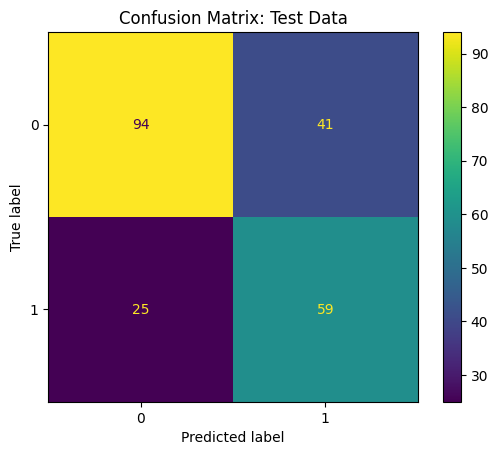

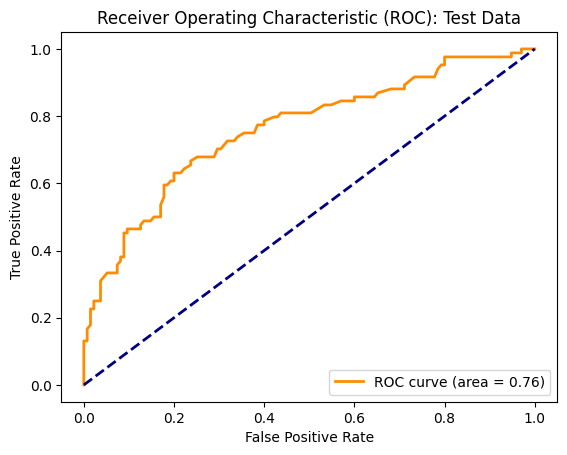

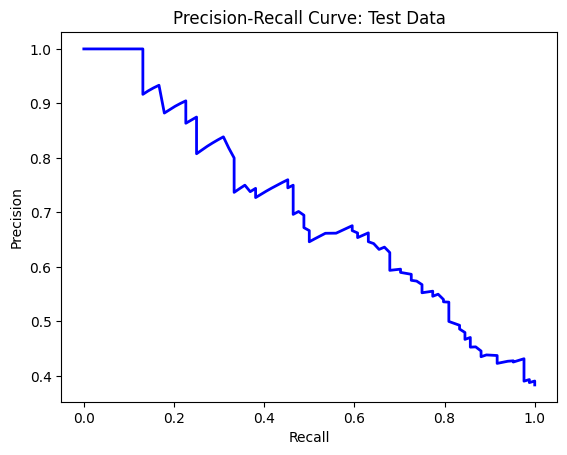

F1-Score: 0.6413043478260869


In [17]:
# Evaluate the initial model on test data
print("Evaluation on Test Data")
evaluate_model(test_y, test_y_pred_rf, test_y_pred_prob_rf, title='Test Data')

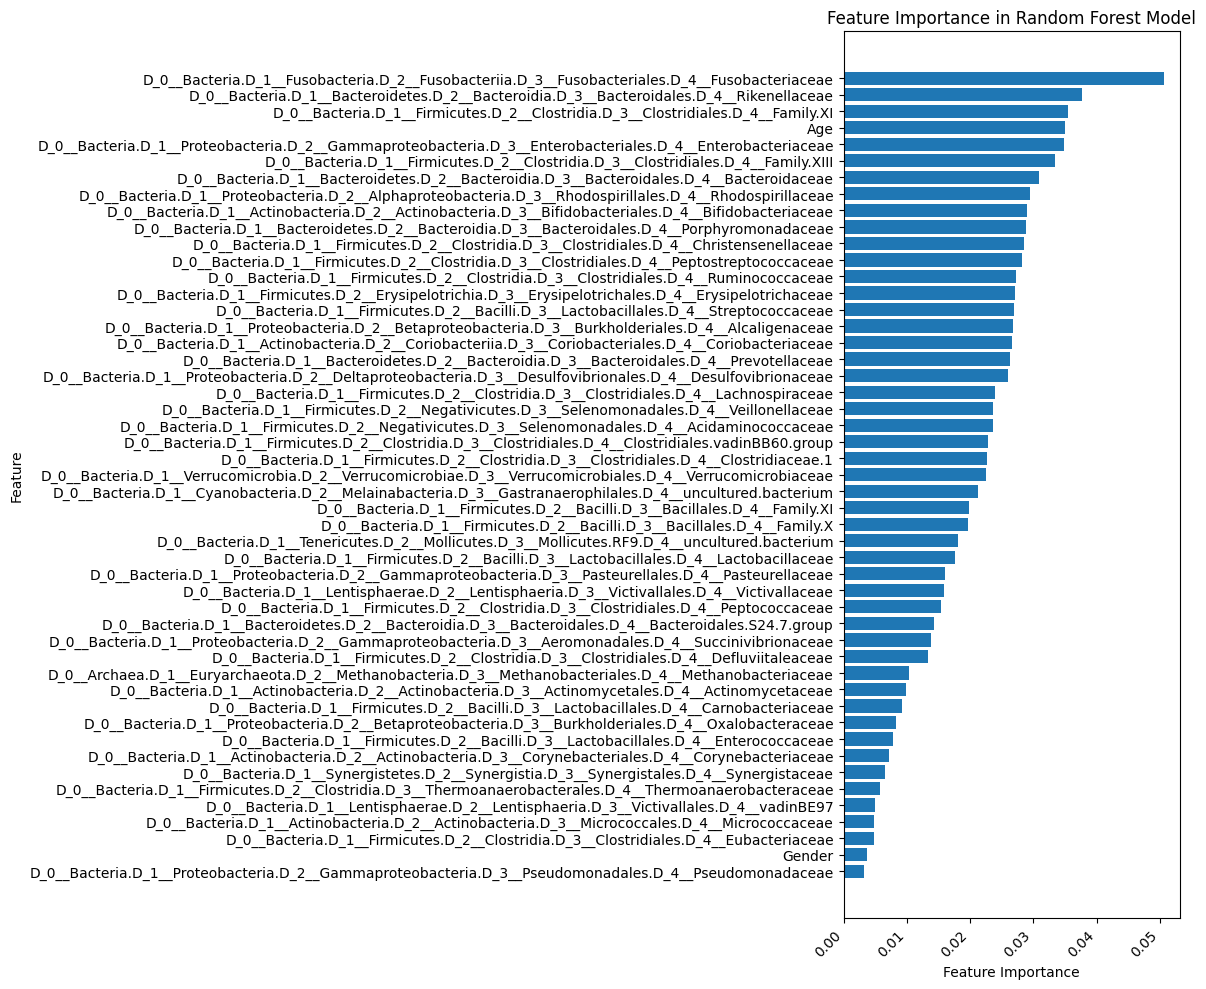

In [18]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

HYPERPARAMETER TUNING OF RF

In [19]:
def objective_rf(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_features = trial.suggest_categorical('max_features', [ 'sqrt', 'log2', None])
    threshold = trial.suggest_float('threshold', 0.1, 0.9)

    # Create the model
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    rf.fit(train_x, train_y)
    
    # Predict and calculate accuracy
    y_pred_prob = rf.predict_proba(test_x)[:, 1]
    y_pred = (y_pred_prob > threshold).astype(int)
    accuracy = accuracy_score(test_y, y_pred)
    return accuracy


In [20]:
# Optimize hyperparameters using Optuna
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=70)

[I 2024-08-06 21:46:44,809] A new study created in memory with name: no-name-72bf121c-ff4a-42a5-ae76-53ea9c7331dc
[I 2024-08-06 21:46:45,415] Trial 0 finished with value: 0.726027397260274 and parameters: {'n_estimators': 145, 'max_depth': 6, 'min_samples_split': 77, 'min_samples_leaf': 43, 'max_features': None, 'threshold': 0.5717164215564704}. Best is trial 0 with value: 0.726027397260274.
[I 2024-08-06 21:46:45,793] Trial 1 finished with value: 0.6164383561643836 and parameters: {'n_estimators': 466, 'max_depth': 40, 'min_samples_split': 81, 'min_samples_leaf': 41, 'max_features': 'log2', 'threshold': 0.8430465875472731}. Best is trial 0 with value: 0.726027397260274.
[I 2024-08-06 21:46:46,117] Trial 2 finished with value: 0.3835616438356164 and parameters: {'n_estimators': 347, 'max_depth': 30, 'min_samples_split': 62, 'min_samples_leaf': 20, 'max_features': 'log2', 'threshold': 0.18563612708348867}. Best is trial 0 with value: 0.726027397260274.
[I 2024-08-06 21:46:46,945] Trial 

In [21]:
# Best hyperparameters
best_params_rf = study_rf.best_params
print("Best hyperparameters: ", best_params_rf)

Best hyperparameters:  {'n_estimators': 567, 'max_depth': 2, 'min_samples_split': 34, 'min_samples_leaf': 42, 'max_features': None, 'threshold': 0.41686943335122706}


In [22]:
# Train the tuned Random Forest model
rf_tuned = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)
rf_tuned.fit(train_x, train_y)

# Predictions
#test_y_pred_tunedrf = rf_tuned.predict(test_x)
test_y_pred_prob_tunedrf = rf_tuned.predict_proba(test_x)[:, 1]
test_y_pred_tunedrf = (test_y_pred_prob_tunedrf > best_params_rf['threshold']).astype(int)

Evaluation on Test Data (Tuned)
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       135
           1       0.73      0.54      0.62        84

    accuracy                           0.74       219
   macro avg       0.74      0.70      0.71       219
weighted avg       0.74      0.74      0.73       219



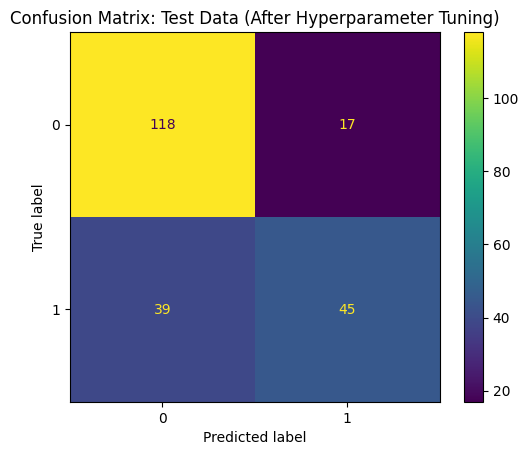

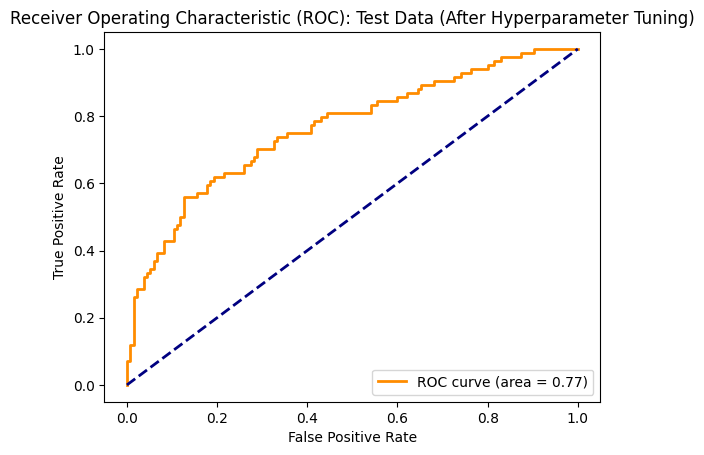

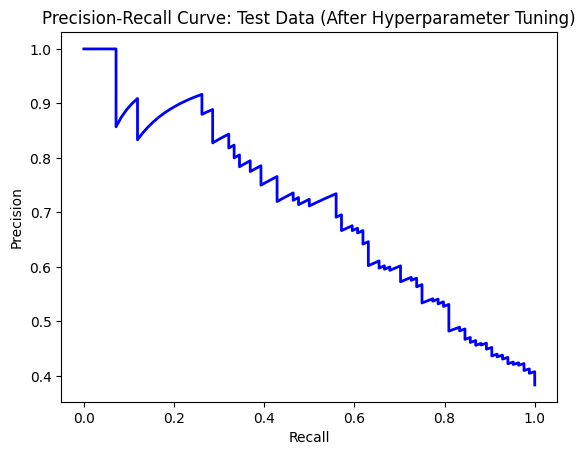

F1-Score: 0.6164383561643836


In [23]:
# Evaluate the tuned model on test data
print("Evaluation on Test Data (Tuned)")
evaluate_model(test_y, test_y_pred_tunedrf, test_y_pred_prob_tunedrf, title='Test Data (After Hyperparameter Tuning)')

In [24]:
# Perform cross-validation on the tuned model
cv_scores_tunedrf = cross_val_score(rf_tuned, train_x, train_y, cv=10, scoring='accuracy')
print("Cross-Validation Accuracy Scores (Tuned): ", cv_scores_tunedrf)
print("Mean Cross-Validation Accuracy (Tuned): ", cv_scores_tunedrf.mean())

Cross-Validation Accuracy Scores (Tuned):  [0.69318182 0.55681818 0.64772727 0.67045455 0.69318182 0.67045455
 0.59770115 0.65517241 0.71264368 0.66666667]
Mean Cross-Validation Accuracy (Tuned):  0.6564002089864159


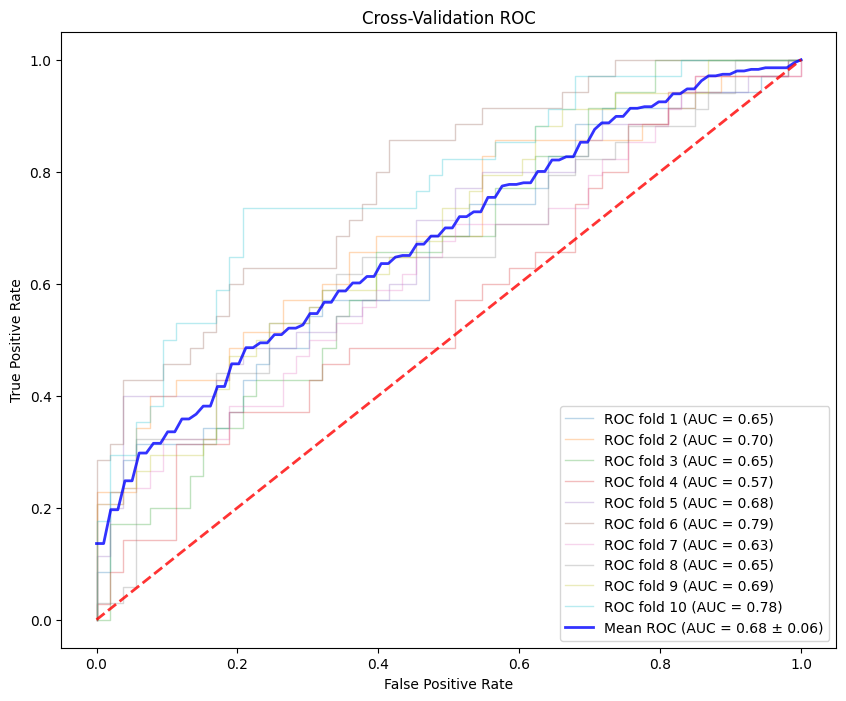

Cross-validation AUC Scores: [0.6549865229110512, 0.6959568733153638, 0.6490566037735849, 0.5735849056603773, 0.6765498652291104, 0.7859838274932615, 0.6298557158712542, 0.6453940066592675, 0.6881243063263042, 0.7785793562708103]
Mean Cross-validation AUC: 0.6781


In [25]:
CV_ROC(rf_tuned, train_x, train_y)

In [114]:
pd.set_option('display.max_colwidth', None)
feature_importances_df.head(10)

Feature  \
35            D_0__Bacteria.D_1__Fusobacteria.D_2__Fusobacteriia.D_3__Fusobacteriales.D_4__Fusobacteriaceae   
0                                                                                                       Age   
12                  D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Rikenellaceae   
25                          D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Family.XI   
26                        D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Family.XIII   
15                                D_0__Bacteria.D_1__Firmicutes.D_2__Bacilli.D_3__Bacillales.D_4__Family.XI   
14                                 D_0__Bacteria.D_1__Firmicutes.D_2__Bacilli.D_3__Bacillales.D_4__Family.X   
30                    D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Ruminococcaceae   
22      D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Clostridiales.vadinBB60.group   
38  D_0__Bacteria.D_1__Proteobacteria.D_2__Alphaproteobacteria.D_3__Rhodospirillales.D_4__Rhodospirillaceae   

    Importance  
35    0.500095  
0     0.110414  
12    0.106655  
25    0.057596  
26    0.041127  
15    0.028218  
14    0.025471  
30    0.024618  
22    0.020014  
38    0.013574

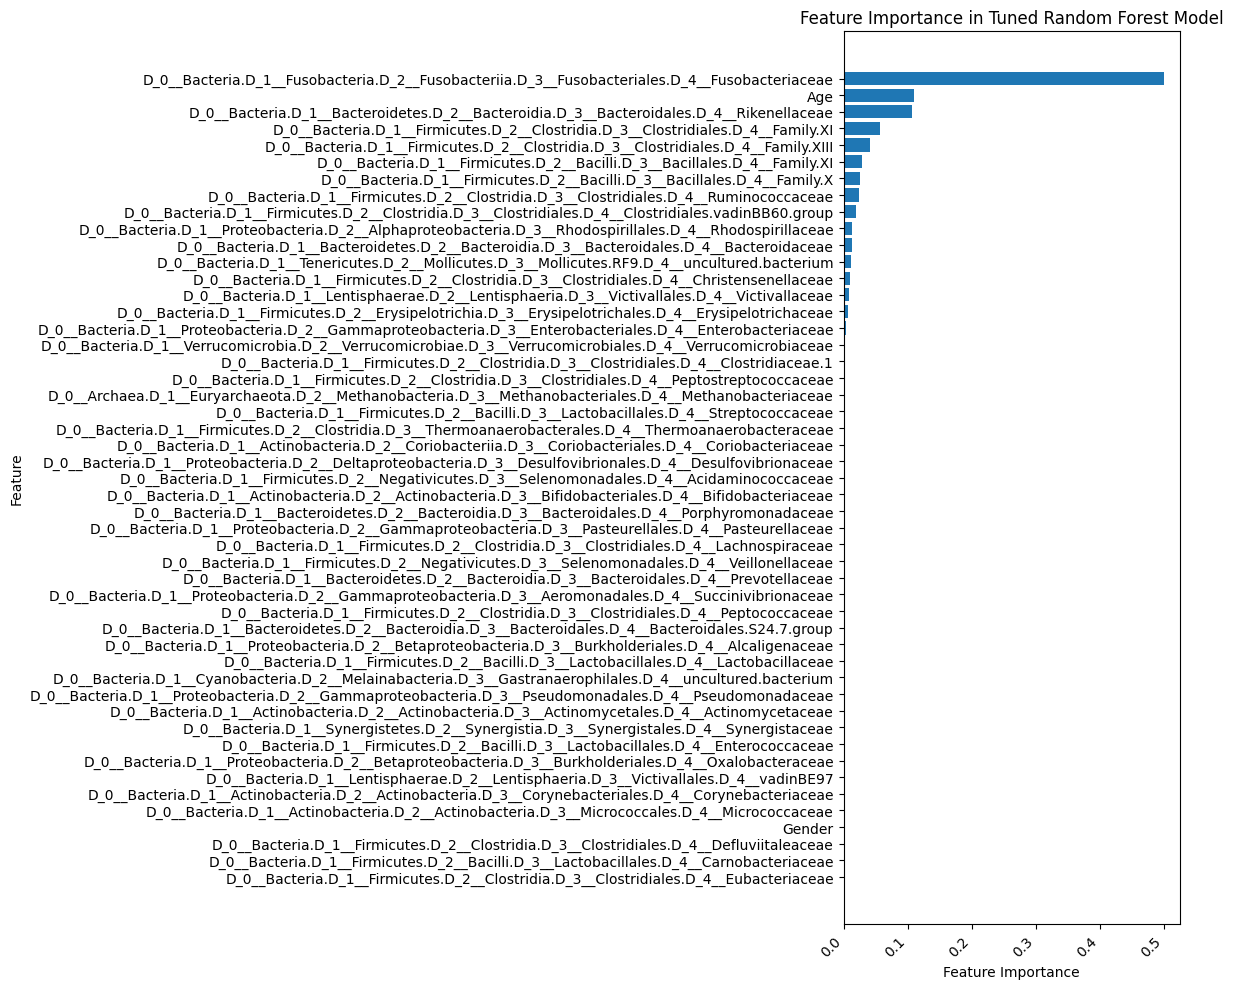

In [112]:
# Get feature importances
importances = rf_tuned.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Tuned Random Forest Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

TRAINING LIGHTGBM

[LightGBM] [Info] Number of positive: 346, number of negative: 530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7934
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394977 -> initscore=-0.426438
[LightGBM] [Info] Start training from score -0.426438
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       135
           1       0.64      0.63      0.63        84

    accuracy                           0.72       219
   macro avg       0.71      0.70      0.70       219
weighted avg       0.72      0.72      0.72       219



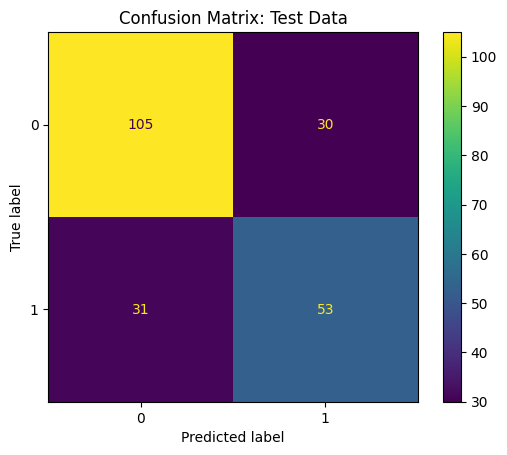

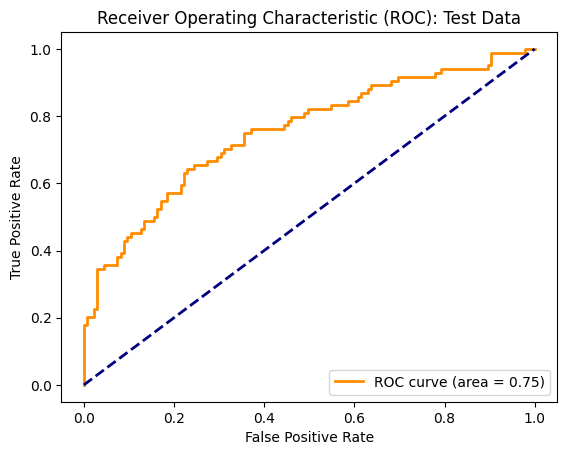

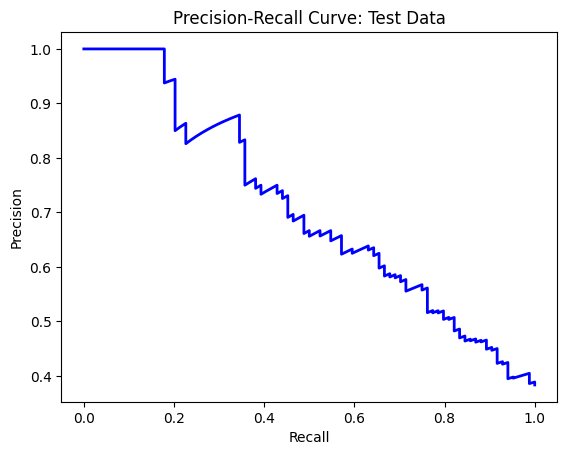

F1-Score: 0.6347305389221557


In [27]:
# Initial training of the model
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(train_x, train_y)


# Predict and evaluate on test data
#y_test_pred_lgb = model_lgb.predict(test_x)
y_test_pred_prob_lgb = model_lgb.predict_proba(test_x)[:, 1]
y_test_pred_lgb = (y_test_pred_prob_lgb > 0.4).astype(int)
evaluate_model(test_y, y_test_pred_lgb, y_test_pred_prob_lgb, title='Test Data')

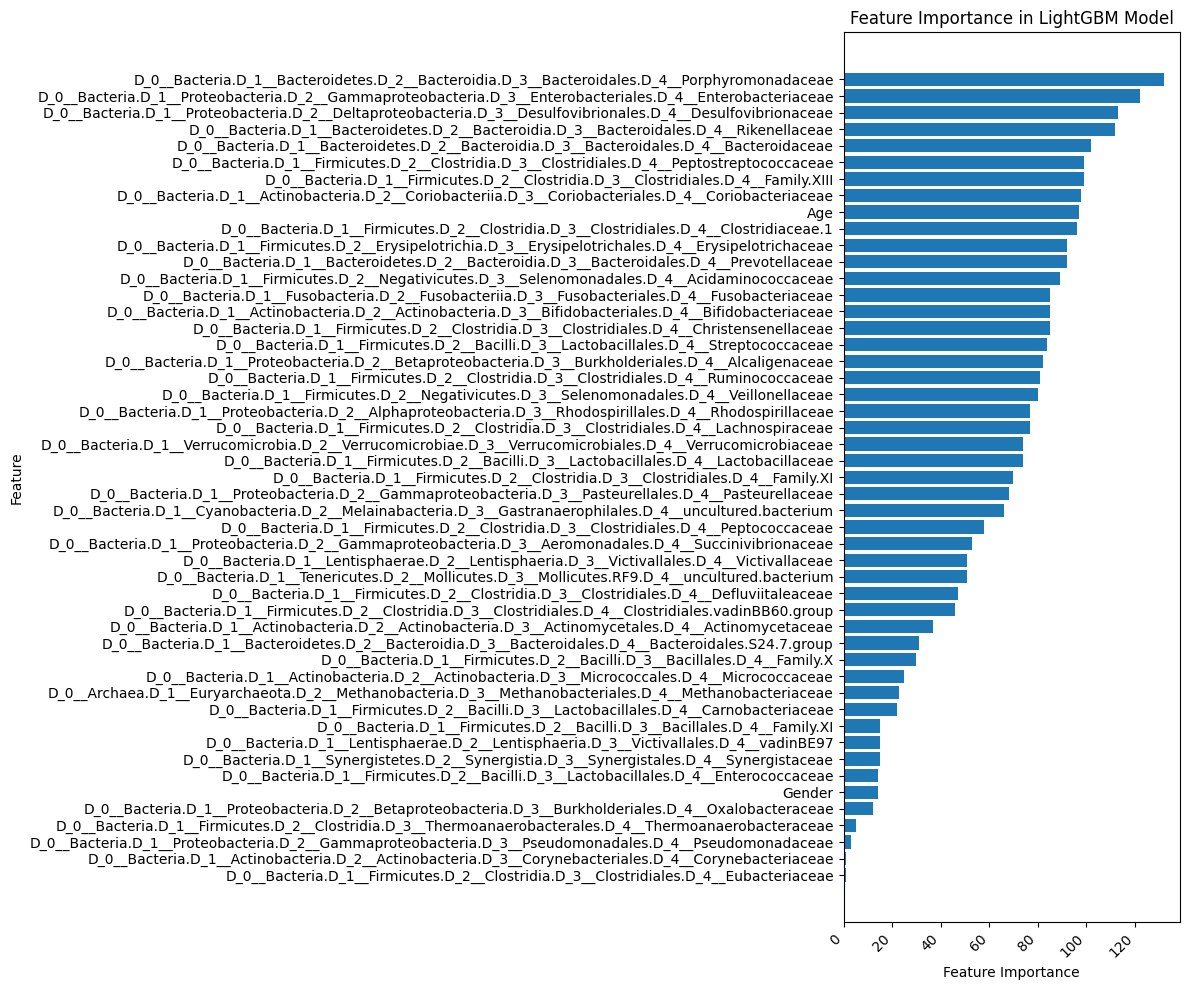

In [28]:
# Get feature importances
importances = model_lgb.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in LightGBM Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [29]:
def objective_lgb(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True)
    }
    threshold = trial.suggest_float('threshold', 0.1, 0.9)

    model = lgb.LGBMClassifier(**param, n_estimators=1000, early_stopping_rounds=50)
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)], eval_metric='logloss')

    y_pred_prob = model.predict_proba(test_x)[:, 1]
    y_pred = (y_pred_prob > threshold).astype(int)
    accuracy = accuracy_score(test_y, y_pred)
    return accuracy

In [30]:
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=50)

[I 2024-08-06 21:52:56,857] A new study created in memory with name: no-name-791eb78d-071a-4fa3-9a0c-ca2d51dcc3b6
[I 2024-08-06 21:52:57,354] Trial 0 finished with value: 0.3835616438356164 and parameters: {'learning_rate': 0.0012715005221656144, 'num_leaves': 40, 'max_depth': 39, 'min_data_in_leaf': 94, 'feature_fraction': 0.8232238363520659, 'bagging_fraction': 0.5848336691637994, 'bagging_freq': 6, 'lambda_l1': 4.273103382456504e-08, 'lambda_l2': 0.00012164438191406486, 'threshold': 0.13428387670222747}. Best is trial 0 with value: 0.3835616438356164.
[I 2024-08-06 21:52:58,126] Trial 1 finished with value: 0.6164383561643836 and parameters: {'learning_rate': 0.0013998834379807114, 'num_leaves': 100, 'max_depth': 5, 'min_data_in_leaf': 52, 'feature_fraction': 0.8863154419639729, 'bagging_fraction': 0.5642415915590103, 'bagging_freq': 5, 'lambda_l1': 0.07383804498149213, 'lambda_l2': 0.0010071579612743152, 'threshold': 0.7488794928279722}. Best is trial 1 with value: 0.61643835616438

In [34]:
# Get the best hyperparameters
best_params_lgb = study_lgb.best_params
print("Best hyperparameters for LightGBM: ", best_params_lgb)

Best hyperparameters for LightGBM:  {'learning_rate': 0.02097003258418912, 'num_leaves': 206, 'max_depth': 23, 'min_data_in_leaf': 34, 'feature_fraction': 0.5054238729134043, 'bagging_fraction': 0.5839894587847058, 'bagging_freq': 3, 'lambda_l1': 0.00029250340645736375, 'lambda_l2': 1.4263383598054171, 'threshold': 0.4982262925246673}


In [35]:
# Train the LightGBM model with best hyperparameters
model_lgb_tuned = lgb.LGBMClassifier(**best_params_lgb, n_estimators=1000)
model_lgb_tuned.fit(train_x, train_y, eval_set=[(test_x, test_y)], eval_metric='binary_logloss')

LGBMClassifier(bagging_fraction=0.5839894587847058, bagging_freq=3,
               feature_fraction=0.5054238729134043,
               lambda_l1=0.00029250340645736375, lambda_l2=1.4263383598054171,
               learning_rate=0.02097003258418912, max_depth=23,
               min_data_in_leaf=34, n_estimators=1000, num_leaves=206,
               threshold=0.4982262925246673)

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       135
           1       0.65      0.57      0.61        84

    accuracy                           0.72       219
   macro avg       0.70      0.69      0.69       219
weighted avg       0.71      0.72      0.71       219



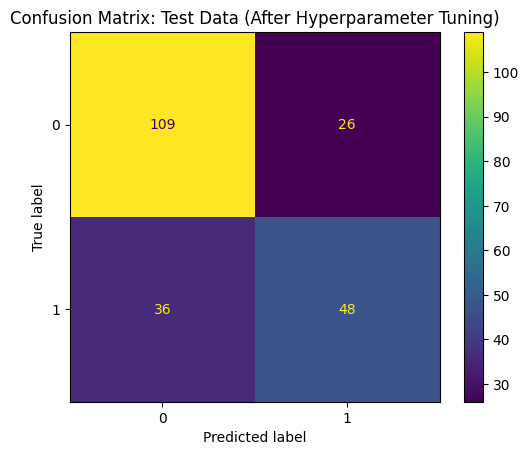

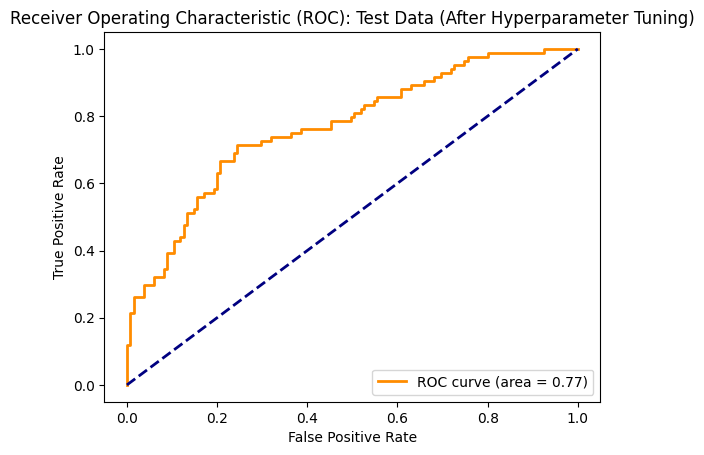

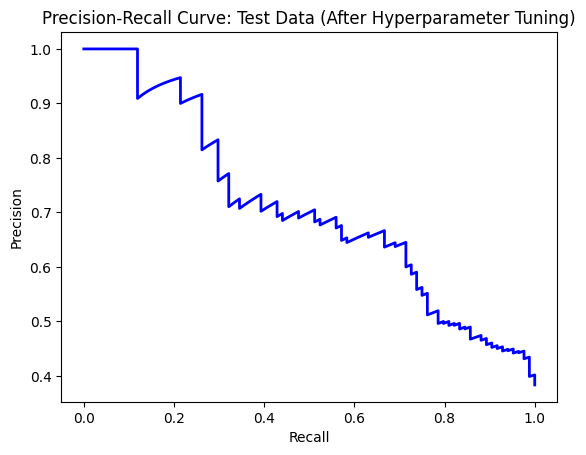

F1-Score: 0.6075949367088608


In [36]:
# Predict and evaluate on test data
#y_test_pred_tunedlgb = model_lgb_tuned.predict(test_x)
y_test_pred_prob_tunedlgb = model_lgb_tuned.predict_proba(test_x)[:, 1]
y_test_pred_tunedlgb = (y_test_pred_prob_tunedlgb > best_params_lgb['threshold']).astype(int)

# Test evaluation with best model
evaluate_model(test_y, y_test_pred_tunedlgb, y_test_pred_prob_tunedlgb, title = "Test Data (After Hyperparameter Tuning)")

In [37]:
# Perform cross-validation on the tuned model
cv_scores_tunedlgb = cross_val_score(model_lgb_tuned, train_x, train_y, cv=10, scoring='accuracy')
print("Cross-Validation Accuracy Scores (Tuned): ", cv_scores_tunedlgb)
print("Mean Cross-Validation Accuracy (Tuned): ", cv_scores_tunedlgb.mean())

Cross-Validation Accuracy Scores (Tuned):  [0.625      0.625      0.625      0.63636364 0.64772727 0.67045455
 0.59770115 0.66666667 0.68965517 0.67816092]
Mean Cross-Validation Accuracy (Tuned):  0.6461729362591432


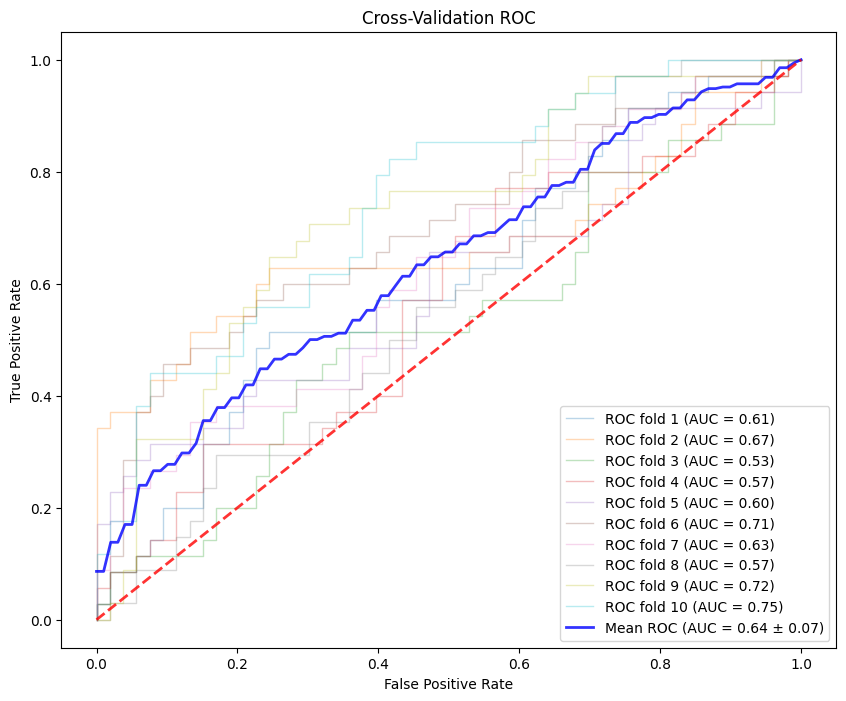

Cross-validation AUC Scores: [0.6113207547169811, 0.6716981132075472, 0.5261455525606469, 0.5665768194070081, 0.5989218328840971, 0.7051212938005392, 0.6315205327413984, 0.572142064372919, 0.720865704772475, 0.7458379578246392]
Mean Cross-validation AUC: 0.6353


In [38]:
CV_ROC(model_lgb_tuned, train_x, train_y)

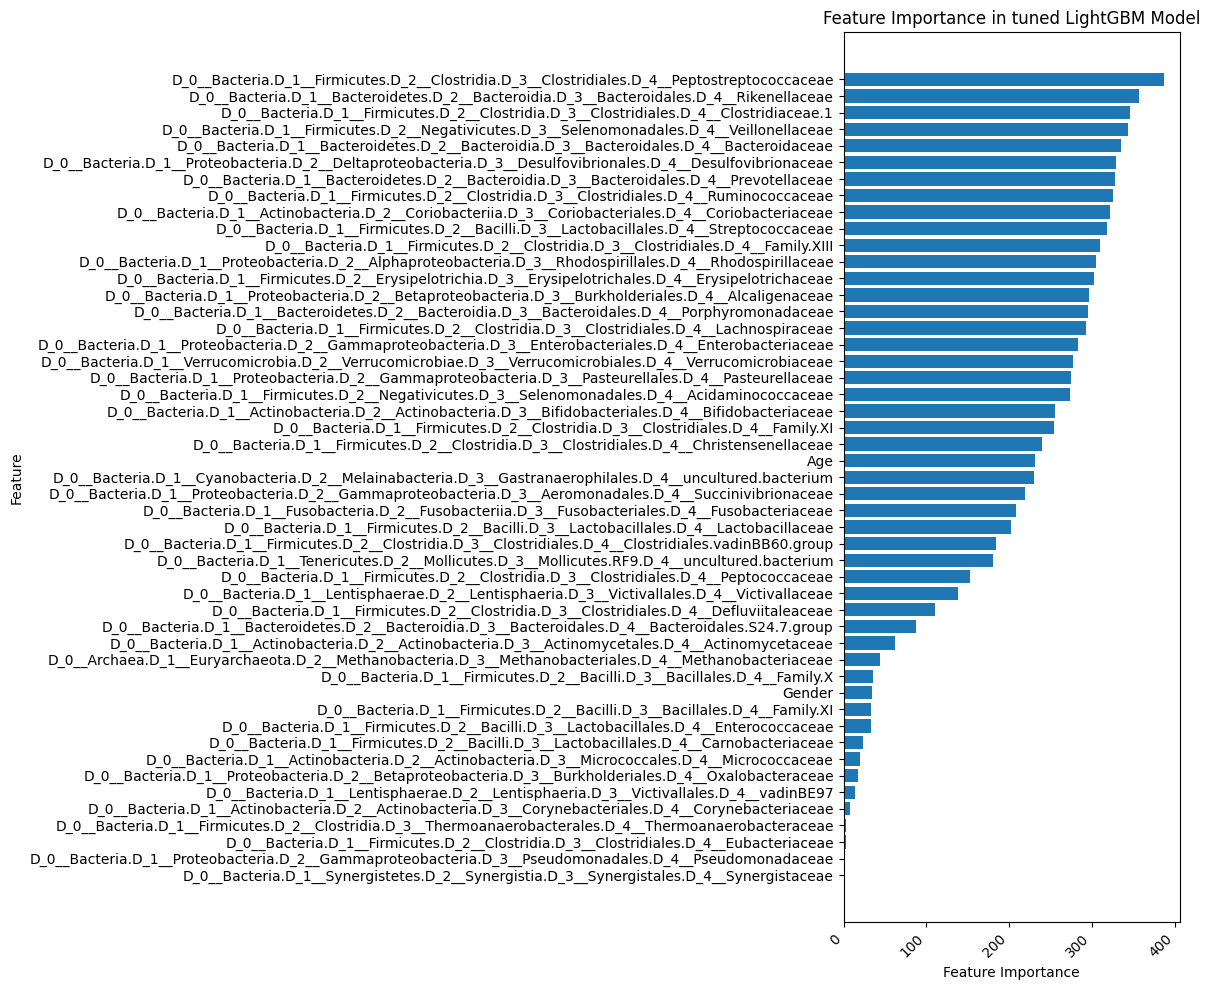

In [117]:
# Get feature importances
importances = model_lgb_tuned.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in tuned LightGBM Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [118]:
feature_importances_df.head(10)

Feature  \
29                  D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Peptostreptococcaceae   
12                      D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Rikenellaceae   
21                       D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Clostridiaceae.1   
34                   D_0__Bacteria.D_1__Firmicutes.D_2__Negativicutes.D_3__Selenomonadales.D_4__Veillonellaceae   
8                      D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Bacteroidaceae   
41  D_0__Bacteria.D_1__Proteobacteria.D_2__Deltaproteobacteria.D_3__Desulfovibrionales.D_4__Desulfovibrionaceae   
11                     D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Prevotellaceae   
30                        D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Ruminococcaceae   
7            D_0__Bacteria.D_1__Actinobacteria.D_2__Coriobacteriia.D_3__Coriobacteriales.D_4__Coriobacteriaceae   
19                        D_0__Bacteria.D_1__Firmicutes.D_2__Bacilli.D_3__Lactobacillales.D_4__Streptococcaceae   

    Importance  
29         387  
12         357  
21         346  
34         343  
8          335  
41         329  
11         328  
30         326  
7          322  
19         318

TRAINING SVM

In [40]:
from sklearn.svm import SVC

In [41]:
svm = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42)
svm.fit(train_x, train_y)

SVC(probability=True, random_state=42)

In [42]:
test_y_pred_prob_svm = svm.predict_proba(test_x)[:, 1]
test_y_pred_svm = (test_y_pred_prob_svm > 0.4).astype(int)

              precision    recall  f1-score   support

           0       0.64      0.66      0.65       135
           1       0.42      0.40      0.41        84

    accuracy                           0.56       219
   macro avg       0.53      0.53      0.53       219
weighted avg       0.56      0.56      0.56       219



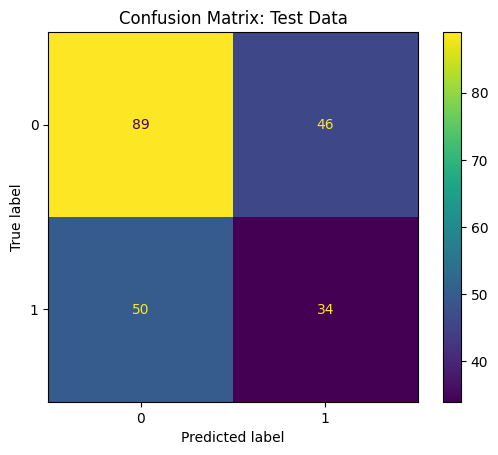

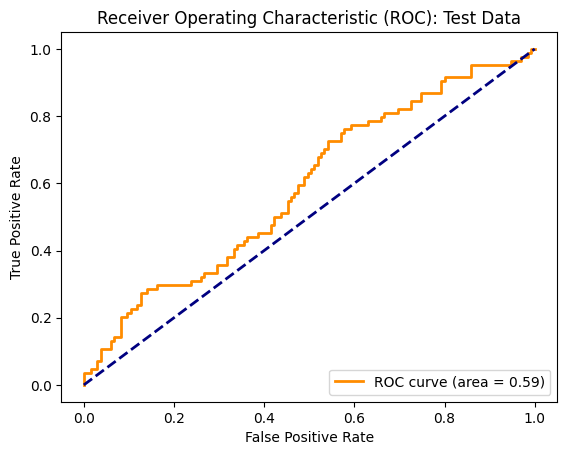

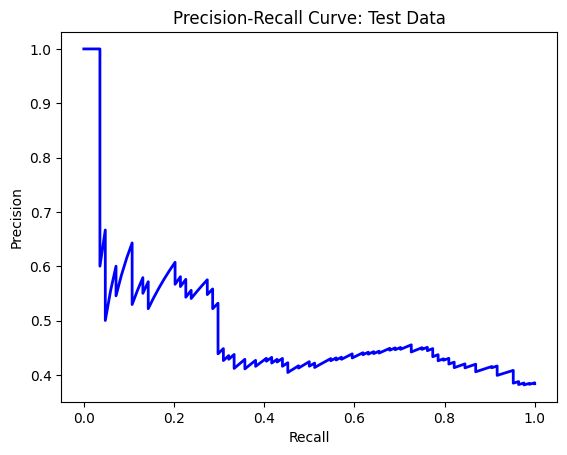

F1-Score: 0.4146341463414634


In [43]:
evaluate_model(test_y, test_y_pred_svm, test_y_pred_prob_svm, title = "Test Data")

In [161]:
# Function to tune hyperparameters using Optuna
def objective_svm(trial):
    # Suggest values for hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    C = trial.suggest_loguniform('C', 1e-3, 1e2)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    degree = trial.suggest_int('degree', 2, 5)
    coef0 = trial.suggest_uniform('coef0', 0.0, 1.0)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    threshold = trial.suggest_float('threshold', 0.1, 0.9)
    
    # Create and fit SVM model
    model = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        degree=degree if kernel == 'poly' else 3,  # degree is used only in 'poly' kernel
        coef0=coef0 if kernel in ['poly', 'sigmoid'] else 0.0,  # coef0 is used in 'poly' and 'sigmoid' kernels
        shrinking=shrinking,
        probability=True,
        random_state=42
    )
    model.fit(train_x, train_y)
    
    # Make predictions and calculate accuracy
    y_pred_prob = model.predict_proba(test_x)[:, 1]
    y_pred = (y_pred_prob > threshold).astype(int)
    accuracy = accuracy_score(test_y, y_pred)
    return accuracy

In [162]:
# Optimize hyperparameters using Optuna
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=70)

[I 2024-08-06 17:03:27,895] A new study created in memory with name: no-name-ed0ad20c-de9a-436b-9ab0-13d77934dd45
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_50795/3823566310.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_50795/3823566310.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_50795/3823566310.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/op

KeyboardInterrupt: 

In [170]:
best_params_svm = study_svm.best_params
best_params_svm

{'kernel': 'poly',
 'C': 0.2565743311405165,
 'gamma': 0.0780726180755951,
 'degree': 4,
 'coef0': 0.45851284222581373,
 'shrinking': True,
 'threshold': 0.41398170761452424}

In [171]:
del best_params_svm['threshold']

In [46]:
svm_params = {
    'kernel': 'poly',
    'C': 0.2565743311405165,
    'gamma': 0.0780726180755951,
    'degree': 4,
    'coef0': 0.45851284222581373,
    'shrinking': True,
}

              precision    recall  f1-score   support

           0       0.69      0.79      0.74       135
           1       0.56      0.44      0.49        84

    accuracy                           0.65       219
   macro avg       0.63      0.61      0.61       219
weighted avg       0.64      0.65      0.64       219



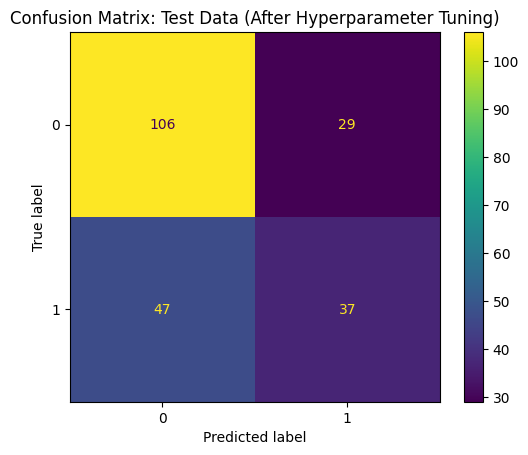

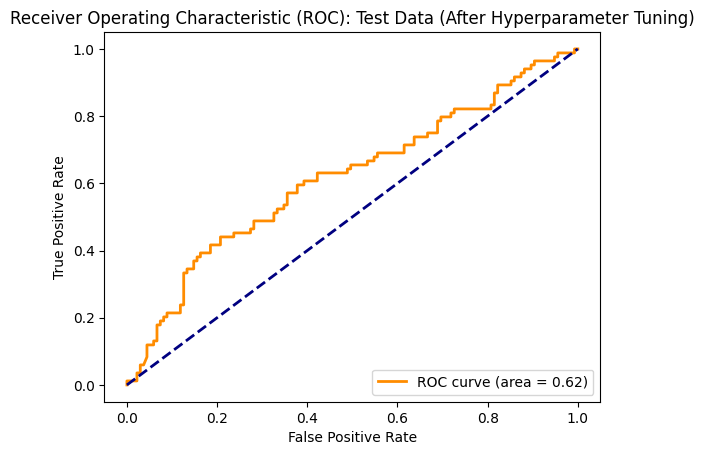

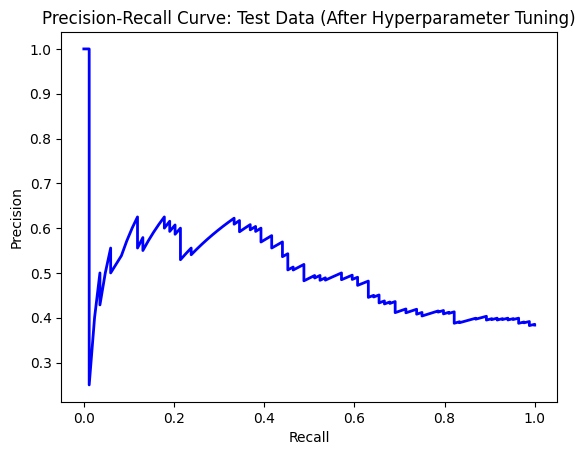

F1-Score: 0.49333333333333335


In [47]:
# Get the best parameters and evaluate the model

svm_tuned = SVC(**svm_params, probability=True, random_state=42)
svm_tuned.fit(train_x, train_y)

# Evaluate the tuned model
test_y_pred_prob_svm_tuned = svm_tuned.predict_proba(test_x)[:, 1]
test_y_pred_svm_tuned = (test_y_pred_prob_svm_tuned > 0.41398170761452424).astype(int)

evaluate_model(test_y, test_y_pred_svm_tuned, test_y_pred_prob_svm_tuned, title = "Test Data (After Hyperparameter Tuning)")

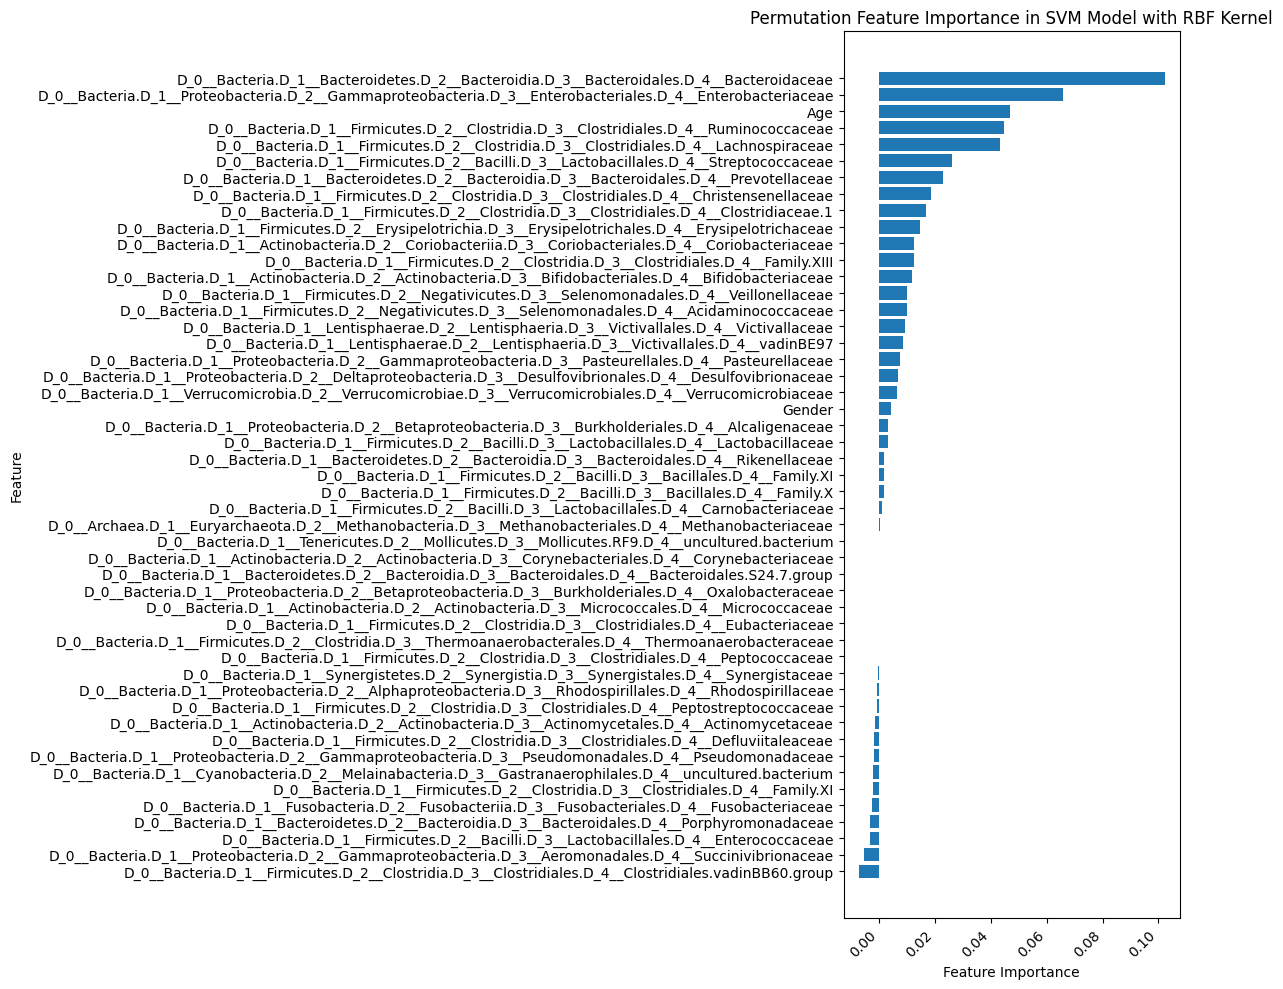

In [49]:
from sklearn.inspection import permutation_importance
# Compute permutation feature importance
result = permutation_importance(svm_tuned, test_x, test_y, n_repeats=10, random_state=42)

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': result.importances_mean
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance in SVM Model with RBF Kernel')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Logistic Regression with Regularisation

In [50]:
logistic_model = LogisticRegression(random_state=42, max_iter=10000, C=1.0, penalty='l2')
logistic_model.fit(train_x, train_y)


LogisticRegression(max_iter=10000, random_state=42)

In [51]:
# Evaluate the tuned model
test_y_pred_prob_logistic = logistic_model.predict_proba(test_x)[:, 1]
test_y_pred_logistic = (test_y_pred_prob_logistic > 0.4).astype(int)

              precision    recall  f1-score   support

           0       0.70      0.58      0.63       135
           1       0.47      0.61      0.53        84

    accuracy                           0.59       219
   macro avg       0.59      0.59      0.58       219
weighted avg       0.61      0.59      0.59       219



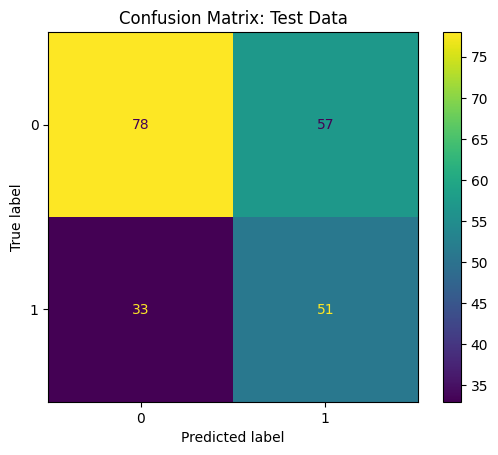

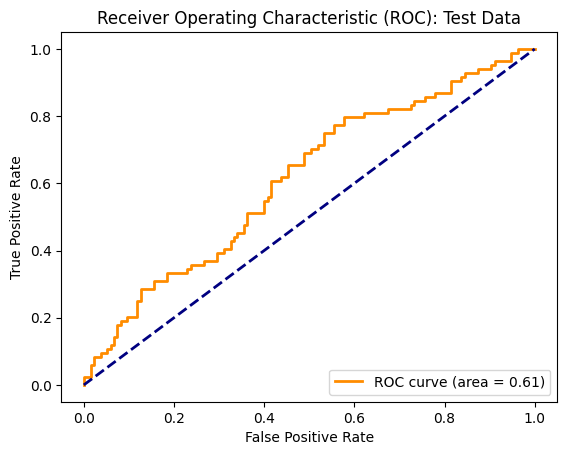

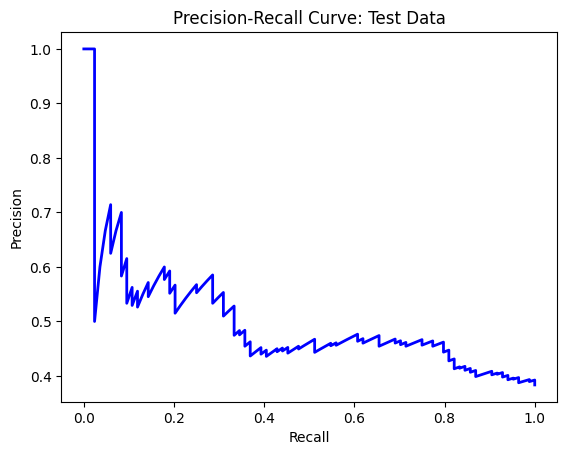

F1-Score: 0.53125


In [52]:
evaluate_model(test_y, test_y_pred_logistic, test_y_pred_prob_logistic, title = "Test Data")

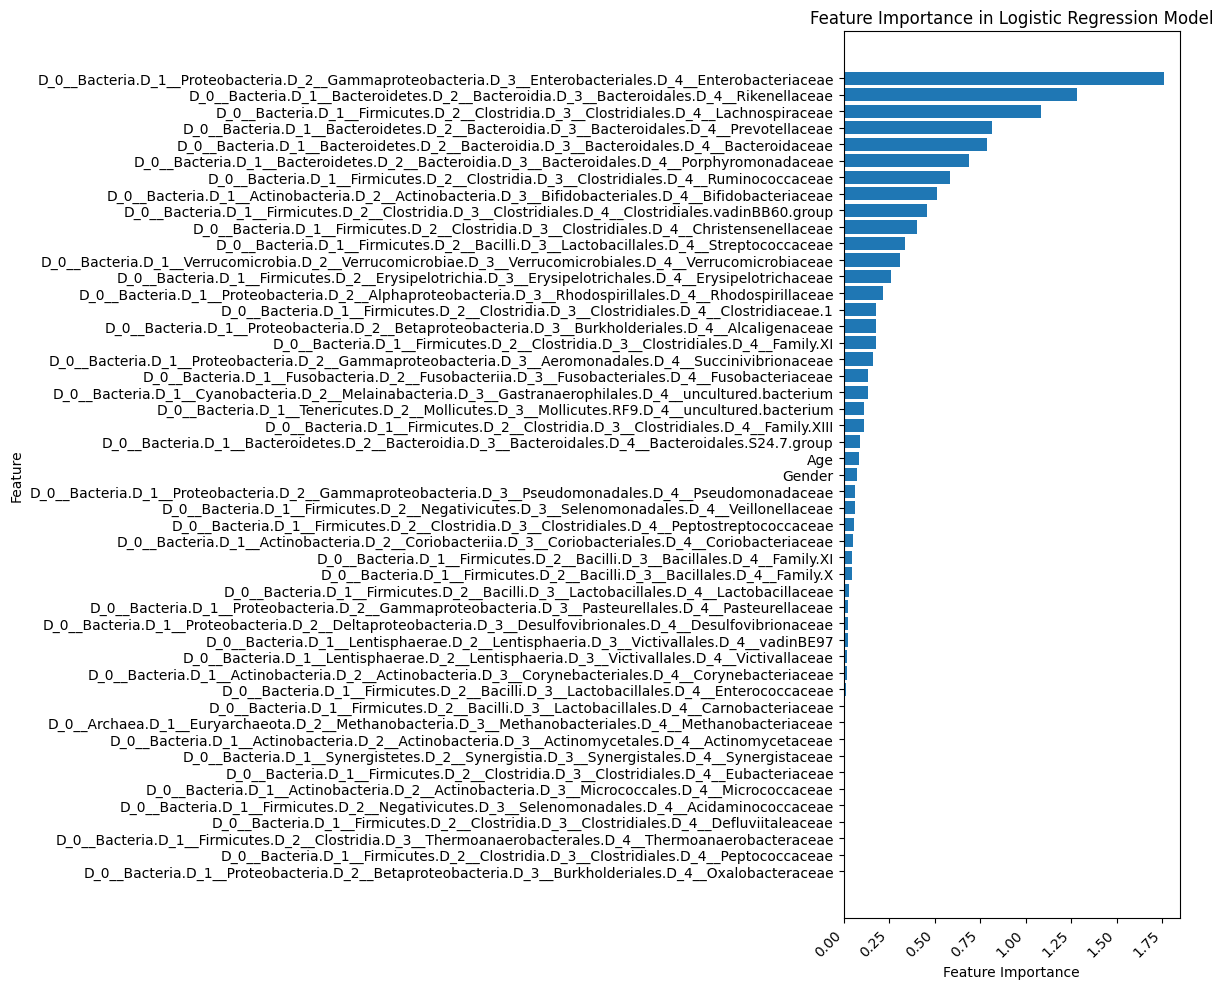

In [53]:
# Get the feature importances (coefficients)
importances = logistic_model.coef_[0]

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': np.abs(importances)  # Taking the absolute value of the coefficients
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [61]:
# Define Objective Function
def objective_lg(trial):
    # Suggest hyperparameters
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    penalty = 'l2' if solver == 'liblinear' else trial.suggest_categorical('penalty', ['l1', 'l2'])
    threshold = trial.suggest_float('threshold', 0.1, 0.9)

    # Create and train the model
    model = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=10000, random_state=42)
    model.fit(train_x, train_y)

    # Evaluate the model with the adjusted threshold
    test_y_pred_prob = model.predict_proba(test_x)[:, 1]
    test_y_pred = (test_y_pred_prob > threshold).astype(int)
    accuracy = accuracy_score(test_y, test_y_pred)
    
    return accuracy

In [62]:
# Hyperparameter Tuning
study_lg = optuna.create_study(direction='maximize')
study_lg.optimize(objective_lg, n_trials=70)

[I 2024-08-06 22:37:32,194] A new study created in memory with name: no-name-67a46b8d-ab7b-483a-93d3-1a6cd87be205
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_61150/2972516686.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-08-06 22:37:32,215] Trial 0 finished with value: 0.3835616438356164 and parameters: {'C': 0.054711763257590966, 'solver': 'liblinear', 'threshold': 0.3620937365011817}. Best is trial 0 with value: 0.3835616438356164.
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_61150/2972516686.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5

In [63]:
print("Best hyperparameters:", study_lg.best_params)

Best hyperparameters: {'C': 5.4195255393171315, 'solver': 'saga', 'penalty': 'l2', 'threshold': 0.46736570325128673}


              precision    recall  f1-score   support

           0       0.68      0.81      0.74       135
           1       0.56      0.39      0.46        84

    accuracy                           0.65       219
   macro avg       0.62      0.60      0.60       219
weighted avg       0.63      0.65      0.63       219



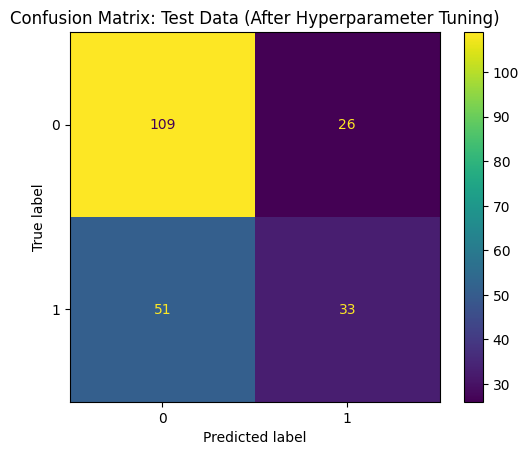

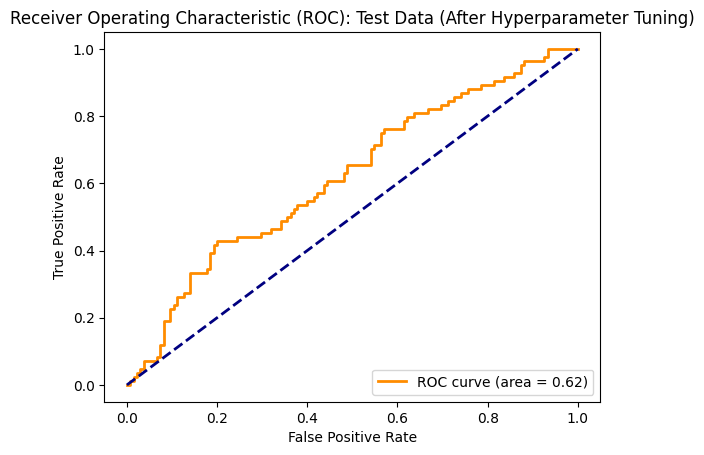

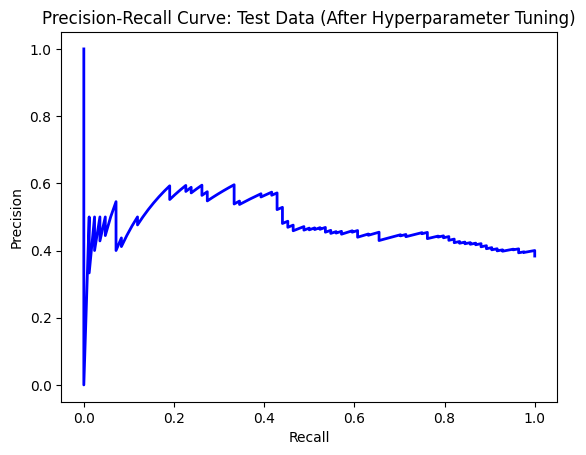

F1-Score: 0.46153846153846156


In [64]:
# Train the final model with the best hyperparameters
lg_tuned = LogisticRegression(
    C=study_lg.best_params['C'],
    solver=study_lg.best_params['solver'],
    penalty='l2' if study_lg.best_params['solver'] == 'liblinear' else study_lg.best_params['penalty'],
    max_iter=10000,
    random_state=42
)
lg_tuned.fit(train_x, train_y)

# Evaluate the final model
test_y_pred_prob_lg_tuned = lg_tuned.predict_proba(test_x)[:, 1]
test_y_pred_lg_tuned = (test_y_pred_prob_lg_tuned > study_lg.best_params['threshold']).astype(int)

evaluate_model(test_y, test_y_pred_lg_tuned, test_y_pred_prob_lg_tuned, title = "Test Data (After Hyperparameter Tuning)")


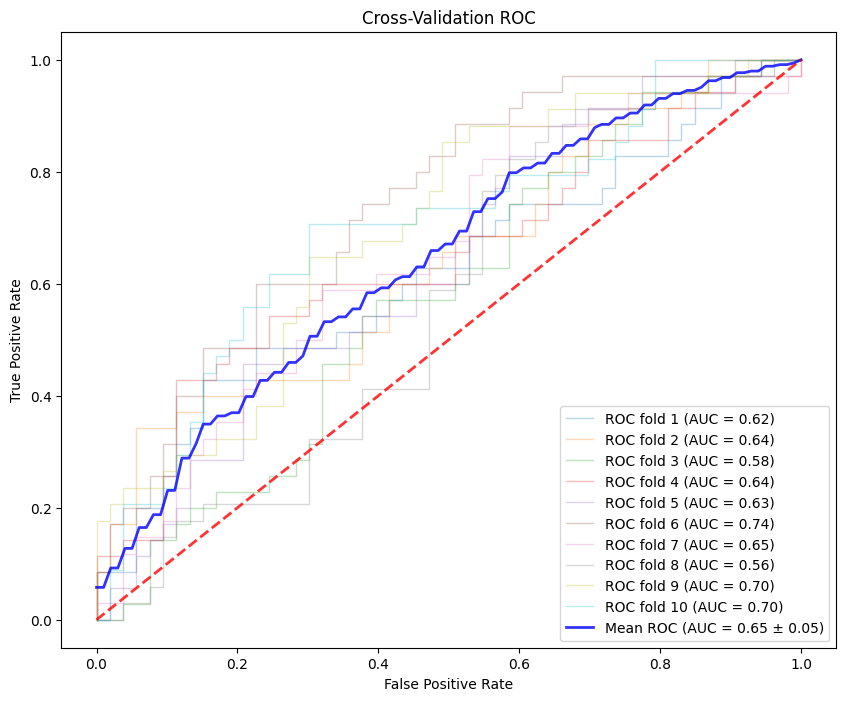

Cross-validation AUC Scores: [0.6188679245283019, 0.6393530997304583, 0.5768194070080862, 0.6436657681940701, 0.631266846361186, 0.7423180592991914, 0.6503884572697003, 0.5643729189789123, 0.6986681465038845, 0.6953385127635959]
Mean Cross-validation AUC: 0.6462


In [65]:
CV_ROC(lg_tuned, train_x, train_y)

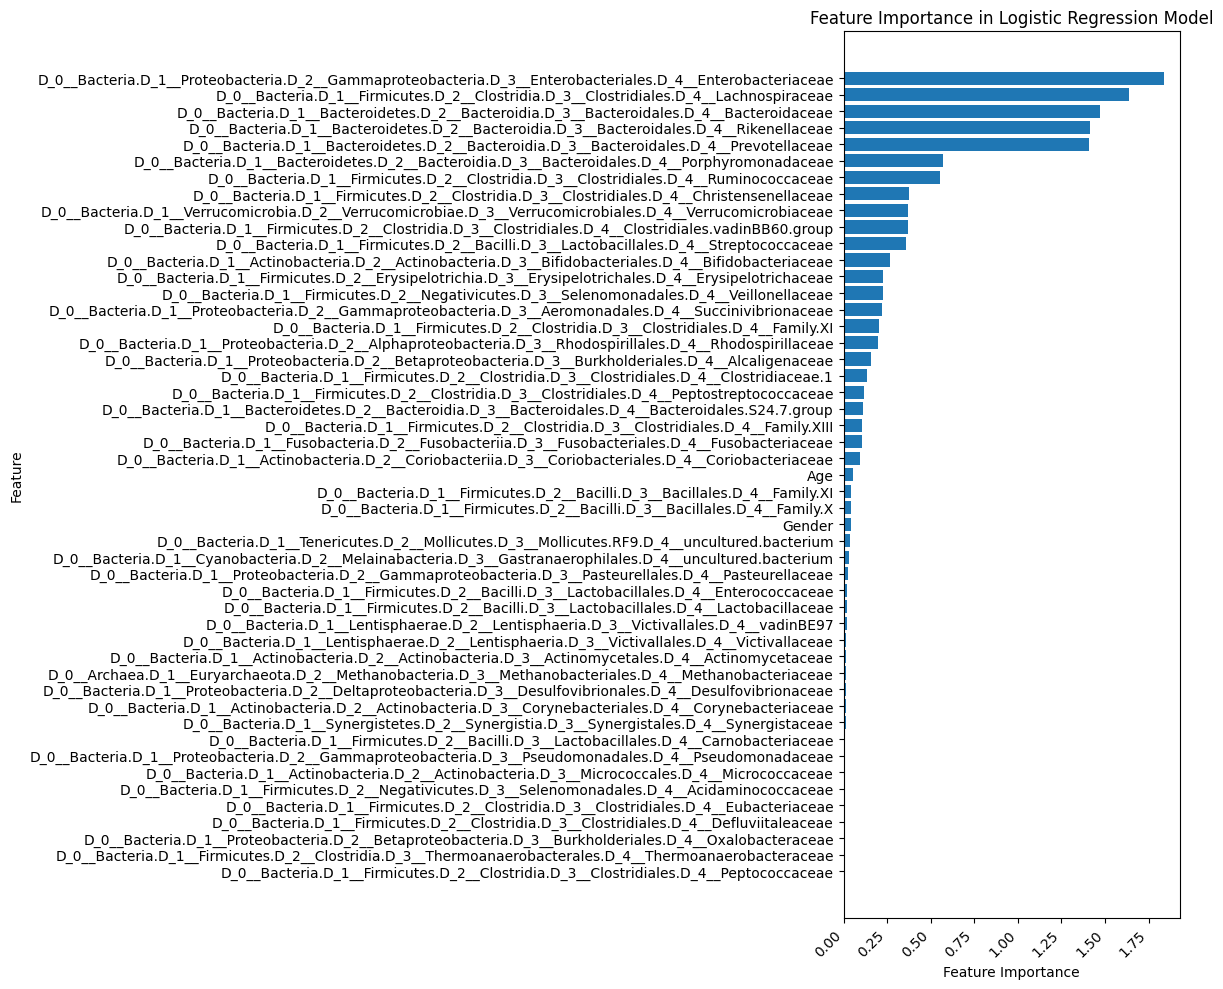

In [115]:
# Get the feature importances (coefficients)
importances = lg_tuned.coef_[0]

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': np.abs(importances)  # Taking the absolute value of the coefficients
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [116]:
feature_importances_df.head(10)

Feature  \
43  D_0__Bacteria.D_1__Proteobacteria.D_2__Gammaproteobacteria.D_3__Enterobacteriales.D_4__Enterobacteriaceae   
27                      D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Lachnospiraceae   
8                    D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Bacteroidaceae   
12                    D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Rikenellaceae   
11                   D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Prevotellaceae   
10               D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Porphyromonadaceae   
30                      D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Ruminococcaceae   
20                  D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Christensenellaceae   
48  D_0__Bacteria.D_1__Verrucomicrobia.D_2__Verrucomicrobiae.D_3__Verrucomicrobiales.D_4__Verrucomicrobiaceae   
22        D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Clostridiales.vadinBB60.group   

    Importance  
43    1.838749  
27    1.639259  
8     1.473814  
12    1.411530  
11    1.411129  
10    0.569938  
30    0.551624  
20    0.375600  
48    0.371928  
22    0.369119

ENSEMBLE MODEL of Tuned Random Forest and LightGBM

In [67]:
from optuna.samplers import TPESampler
from sklearn.ensemble import StackingClassifier

In [120]:
# Define the StackingClassifier with the tuned meta-model
base_models_tuned = [
    ('rf', rf_tuned),
    ('lgbm', model_lgb_tuned)
]

In [69]:
meta_model = LogisticRegression()

In [70]:
stacking_clf = StackingClassifier(estimators=base_models_tuned, final_estimator=meta_model, cv=5)

In [71]:
stacking_clf.fit(train_x, train_y)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=2,
                                                       max_features=None,
                                                       min_samples_leaf=42,
                                                       min_samples_split=34,
                                                       n_estimators=567,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(bagging_fraction=0.5839894587847058,
                                               bagging_freq=3,
                                               feature_fraction=0.5054238729134043,
                                               lambda_l1=0.00029250340645736375,
                                               lambda_l2=1.4263383598054171,
                                               learning_rate=0.02097003258418912,
                                               max_depth=23,
                                               min_data_in_leaf=34,
                                               n_estimators=1000,
                                               num_leaves=206,
                                               threshold=0.4982262925246673))],
                   final_estimator=LogisticRegression())

In [72]:
# Make predictions on the test set
test_y_pred_prob_ensemble = stacking_clf.predict_proba(test_x)[:, 1]
test_y_pred_ensemble = (test_y_pred_prob_ensemble > 0.4).astype(int)

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       135
           1       0.68      0.64      0.66        84

    accuracy                           0.74       219
   macro avg       0.73      0.73      0.73       219
weighted avg       0.74      0.74      0.74       219



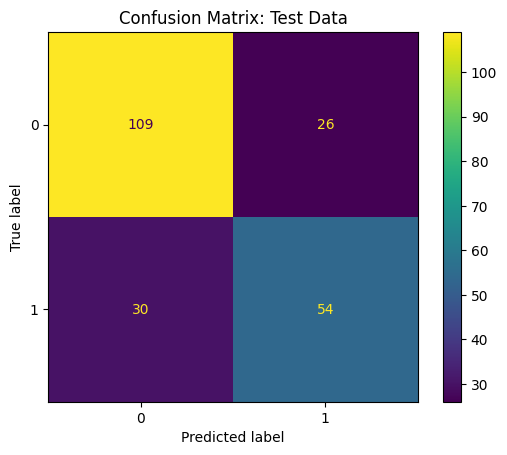

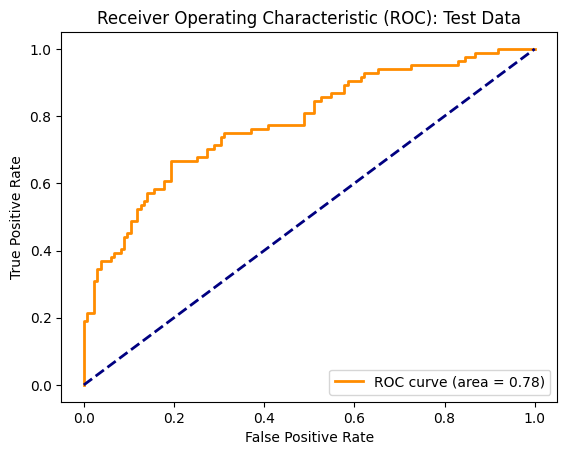

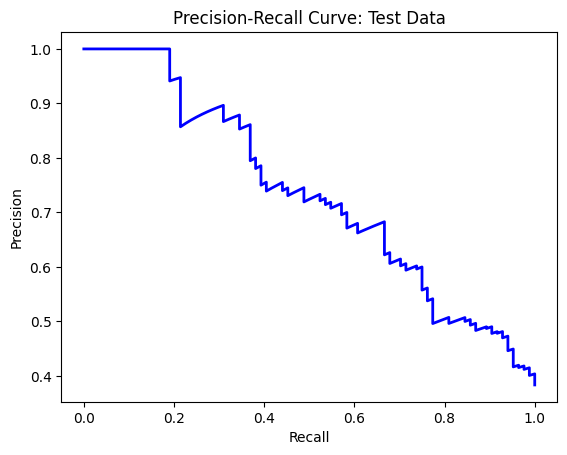

F1-Score: 0.6585365853658537


In [74]:
evaluate_model(test_y, test_y_pred_ensemble, test_y_pred_prob_ensemble, title = "Test Data")

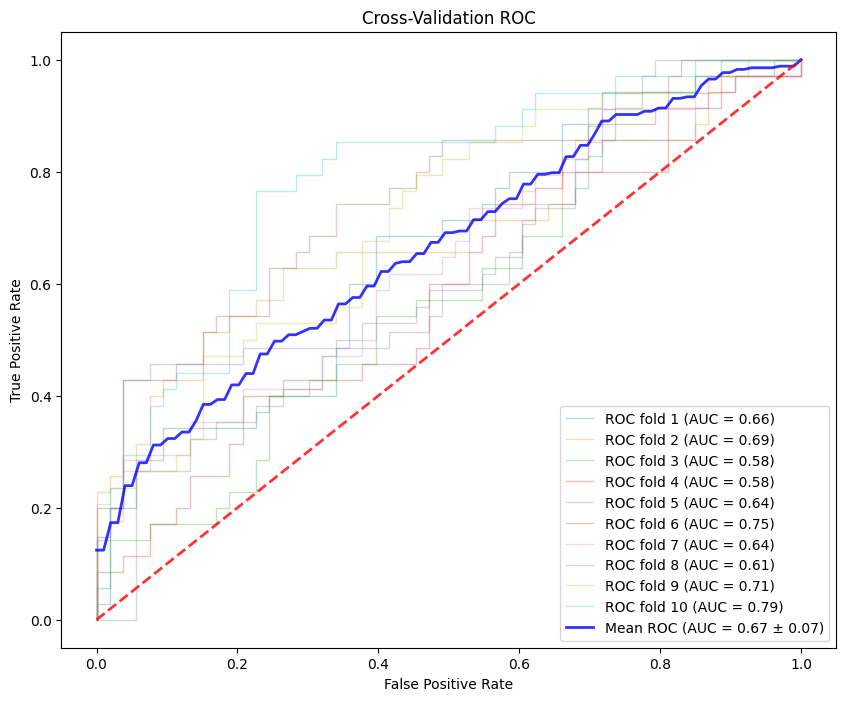

Cross-validation AUC Scores: [0.6576819407008087, 0.6857142857142857, 0.5827493261455525, 0.5827493261455525, 0.6355795148247978, 0.7525606469002695, 0.6381798002219756, 0.6143174250832408, 0.7103218645948945, 0.7885682574916759]
Mean Cross-validation AUC: 0.6652


In [86]:
CV_ROC(stacking_clf, train_x, train_y)

In [76]:
#Hyperparameter tuning of Ensemble model:

# Define the objective function for tuning the meta-model
def objective_meta(trial):
    # Define hyperparameters for Logistic Regression
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    penalty = 'l2' if solver == 'liblinear' else trial.suggest_categorical('penalty', ['l1', 'l2'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    threshold = trial.suggest_float('threshold', 0.1, 0.9)


    meta_model = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=max_iter, random_state=42)

    stacking_clf = StackingClassifier(estimators=base_models_tuned, final_estimator=meta_model, cv=5)

    # Train the stacking classifier
    stacking_clf.fit(train_x, train_y)
    
    test_y_pred_prob = stacking_clf.predict_proba(test_x)[:, 1]
    test_y_pred = (test_y_pred_prob > threshold).astype(int)
    
    # Calculate the accuracy
    accuracy = accuracy_score(test_y, test_y_pred)
    
    return accuracy

In [77]:
study_meta = optuna.create_study(direction='maximize', sampler=TPESampler())
study_meta.optimize(objective_meta, n_trials=70)

[I 2024-08-06 23:07:18,854] A new study created in memory with name: no-name-c9094c71-eaf2-4816-80d9-55789f24c136
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_61150/2303748707.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-08-06 23:07:30,426] Trial 0 finished with value: 0.3835616438356164 and parameters: {'C': 0.0143789309845125, 'solver': 'liblinear', 'max_iter': 496, 'threshold': 0.2811020546759558}. Best is trial 0 with value: 0.3835616438356164.
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_61150/2303748707.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_logun

In [78]:
# Get the best parameters for the meta-model
best_meta_params = study_meta.best_params
print("Best Meta-Model params:", best_meta_params)

Best Meta-Model params: {'C': 3.1012858288472844, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 996, 'threshold': 0.470736357916803}


In [80]:
del best_meta_params['threshold']

In [81]:
best_meta_params

{'C': 3.1012858288472844, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 996}

In [82]:
# Define the tuned meta-model
meta_model_tuned = LogisticRegression(**best_meta_params)

# Create the stacking classifier with the tuned meta-model
stacking_clf_tuned = StackingClassifier(estimators=base_models_tuned, final_estimator=meta_model_tuned)


In [83]:
# Train the stacking classifier with tuned meta-model
stacking_clf_tuned.fit(train_x, train_y)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=2,
                                                       max_features=None,
                                                       min_samples_leaf=42,
                                                       min_samples_split=34,
                                                       n_estimators=567,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(bagging_fraction=0.5839894587847058,
                                               bagging_freq=3,
                                               feature_fraction=0.5054238729134043,
                                               lambda_l1=0.00029250340645736375,
                                               lambda_l2=1.4263383598054171,
                                               learning_rate=0.02097003258418912,
                                               max_depth=23,
                                               min_data_in_leaf=34,
                                               n_estimators=1000,
                                               num_leaves=206,
                                               threshold=0.4982262925246673))],
                   final_estimator=LogisticRegression(C=3.1012858288472844,
                                                      max_iter=996,
                                                      solver='saga'))

In [84]:
# Make predictions on the test set
test_y_pred_prob_ensemble_tuned = stacking_clf_tuned.predict_proba(test_x)[:, 1]
test_y_pred_ensemble_tuned = (test_y_pred_prob_ensemble_tuned > 0.470736357916803).astype(int)

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       135
           1       0.77      0.51      0.61        84

    accuracy                           0.75       219
   macro avg       0.76      0.71      0.72       219
weighted avg       0.76      0.75      0.74       219



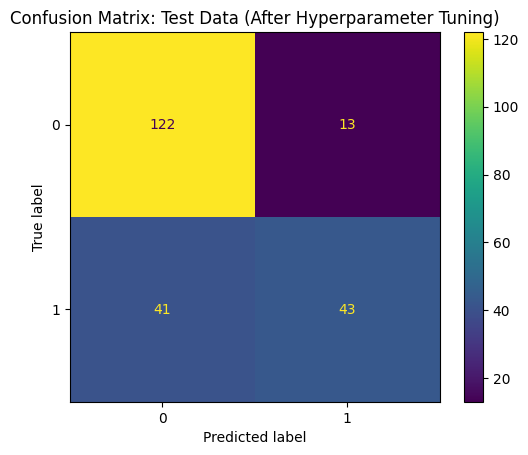

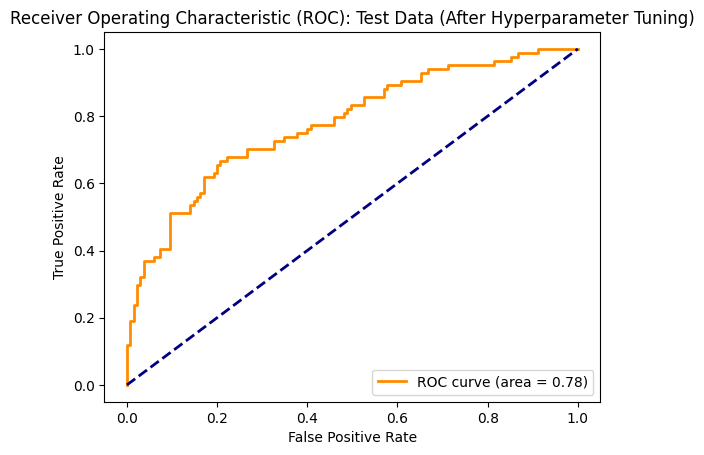

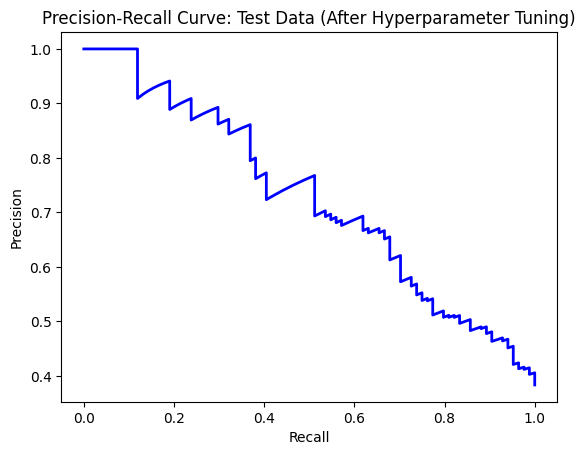

F1-Score: 0.6142857142857143


In [85]:
evaluate_model(test_y, test_y_pred_ensemble_tuned, test_y_pred_prob_ensemble_tuned, title = "Test Data (After Hyperparameter Tuning)")

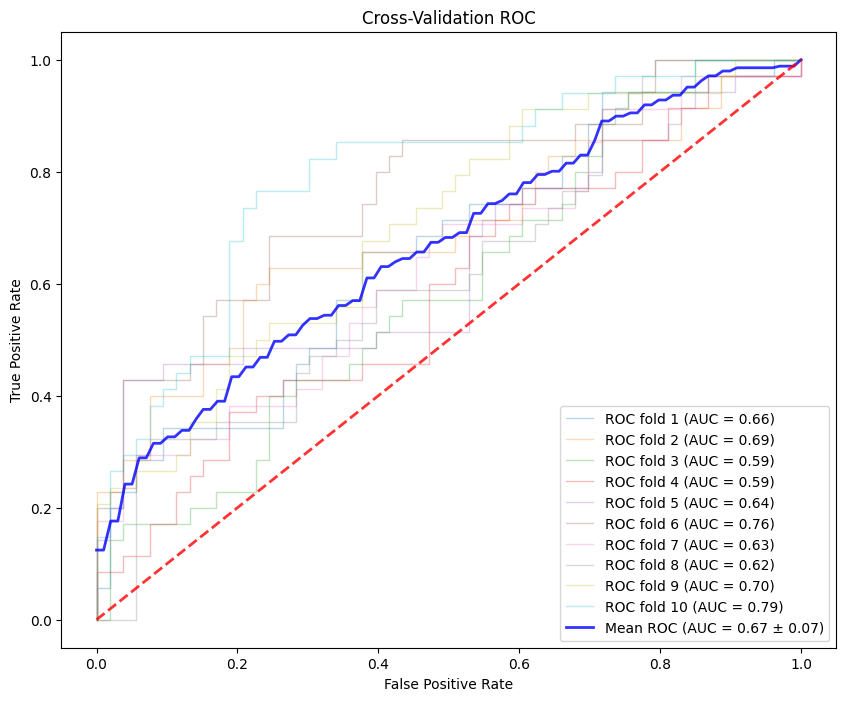

Cross-validation AUC Scores: [0.6566037735849056, 0.6862533692722373, 0.5913746630727763, 0.5870619946091644, 0.64366576819407, 0.7649595687331536, 0.6337402885682575, 0.6204217536071032, 0.7014428412874584, 0.793007769145394]
Mean Cross-validation AUC: 0.6682


In [87]:
CV_ROC(stacking_clf_tuned, train_x, train_y)